<a href="https://colab.research.google.com/github/Kenz2000/Supervised-learning-project/blob/main/Copie_de_Credit_clients_supervised_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
pip install imbalanced-learn

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, KFold
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
# it's a library that we work with plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)                  # this code, allow us to work with offline plotly version
import plotly.graph_objs as go                         # it's like "plt" of matplot
import plotly.tools as tls                             # It's useful to we get some tools of plotly
from collections import Counter                        # To do counter of some features
import plotly.figure_factory as ff

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv",
                 names=["status_cce","duree_mois","hist_credit","obj","montant_credit","compte_epargne","emplois_depuis",
"taux_vers_revenu","status_sexe","autres_debits","residence_depuis","prop","age","plans_vers","log","nbr_credits","travail","nbr_per_charge",
"tel","trav_etranger","label"],index_col=False)

In [5]:
df.head()

,status_cce,duree_mois,hist_credit,obj,montant_credit,compte_epargne,emplois_depuis,taux_vers_revenu,status_sexe,autres_debits,...,prop,age,plans_vers,log,nbr_credits,travail,nbr_per_charge,tel,trav_etranger,label
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [6]:
df.isnull().sum()

status_cce          0
duree_mois          0
hist_credit         0
obj                 0
montant_credit      0
compte_epargne      0
emplois_depuis      0
taux_vers_revenu    0
status_sexe         0
autres_debits       0
residence_depuis    0
prop                0
age                 0
plans_vers          0
log                 0
nbr_credits         0
travail             0
nbr_per_charge      0
tel                 0
trav_etranger       0
label               0
dtype: int64

In [7]:

df['taux_vers_revenu'].unique()
#Je pense que cette variable est qualitative

array([4, 2, 3, 1])

In [8]:
df["residence_depuis"].unique()
#Je pense que c'est une variable qualitative

array([4, 2, 3, 1])

In [9]:
df["residence_depuis"].value_counts()

4    413
2    308
3    149
1    130
Name: residence_depuis, dtype: int64

In [10]:
numerical_vars = ['duree_mois', 'montant_credit', 'age', 'nbr_credits']
int_categ_vars = ["taux_vers_revenu", "residence_depuis", "nbr_per_charge"]

In [11]:
categorical_vars = df.select_dtypes(include=['object']).columns.to_list()
categorical_vars.extend(int_categ_vars)
bank_numerical = list(set(df.select_dtypes(include=['int']).columns.to_list()) - set(categorical_vars))
bank_numerical.remove('label')
len(categorical_vars)
#On retrouve bien les 16 variables catégorielles

16

In [12]:
df['label'].unique()

array([1, 2])

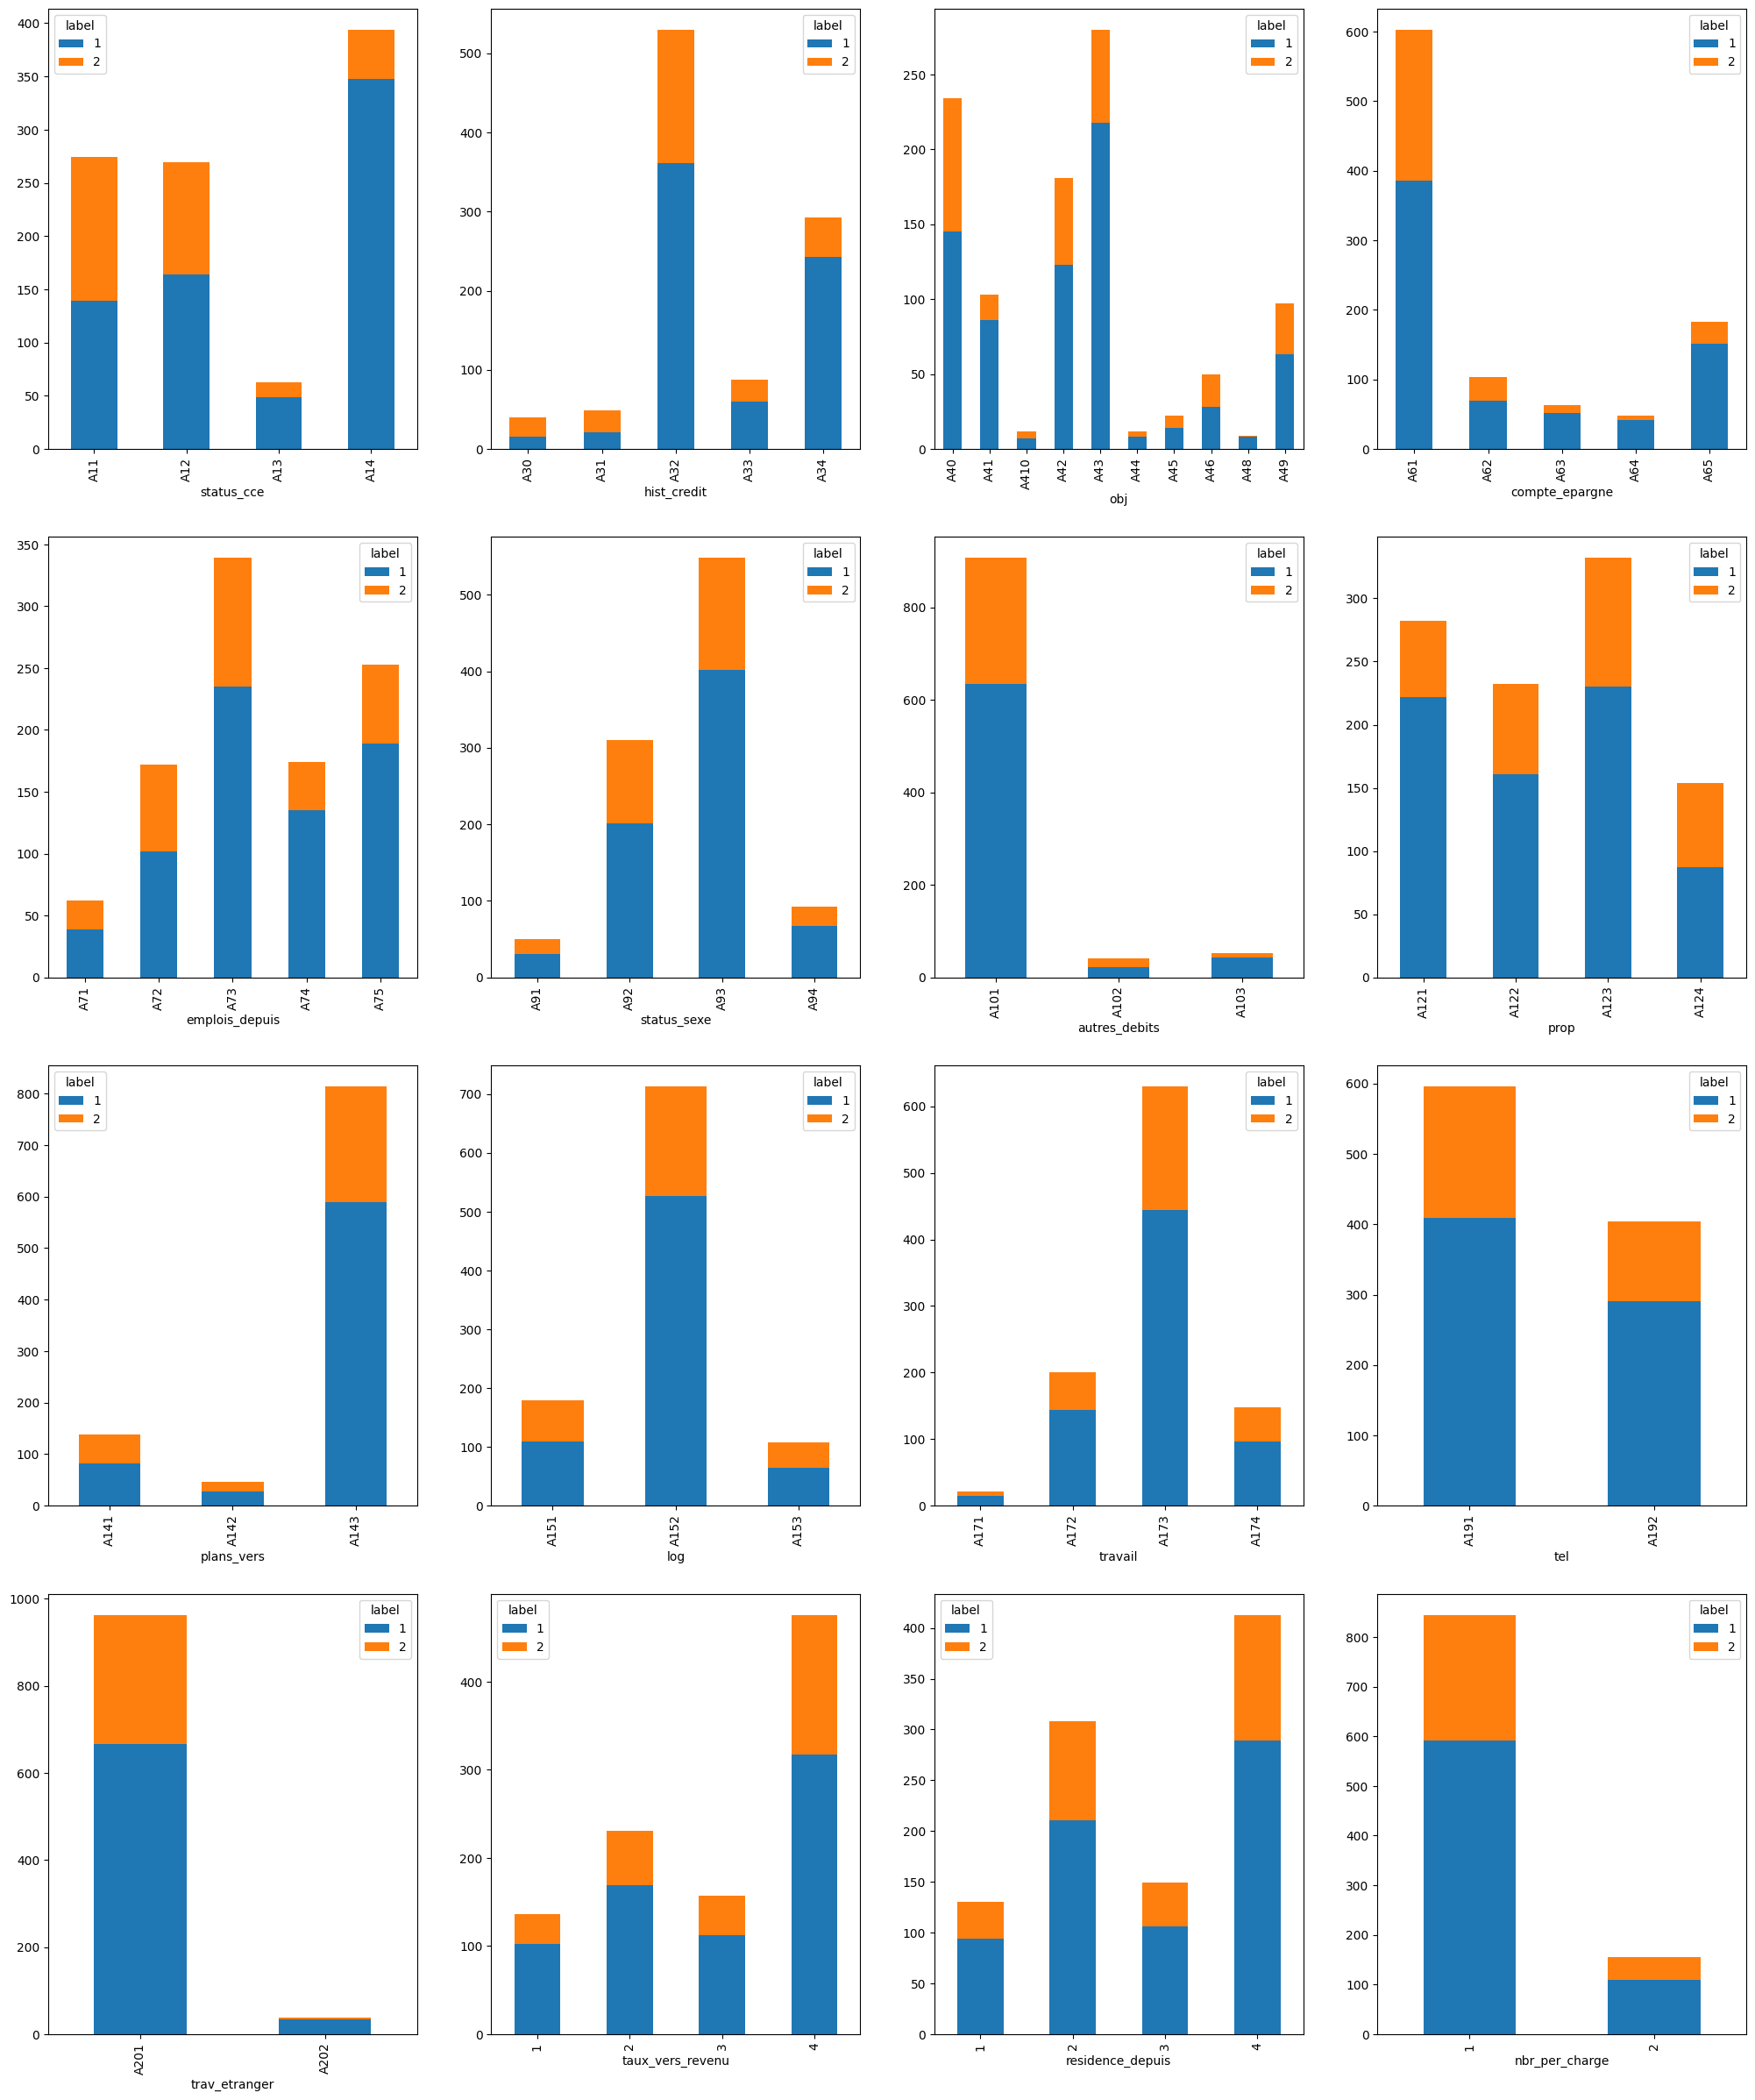

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25, 30))
for xcol, ax in zip(categorical_vars, [x for v in axes for x in v]):
    df.groupby([xcol, 'label']).size().unstack("label").plot.bar(ax=ax,stacked=True)

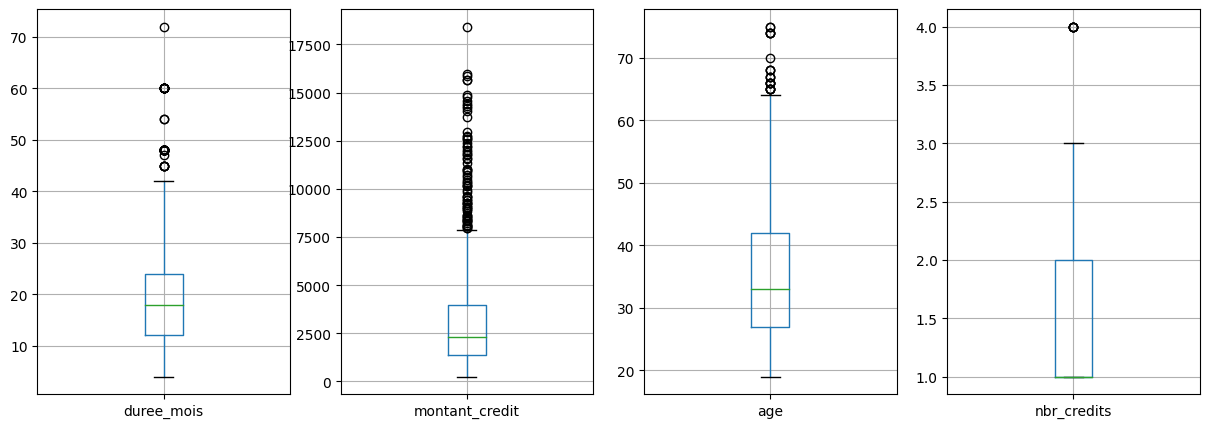

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
for xcol, ax in zip(numerical_vars, [x for x in axes.flat]):
    df.boxplot(ax=ax, column=[xcol])

<Axes: xlabel='duree_mois'>

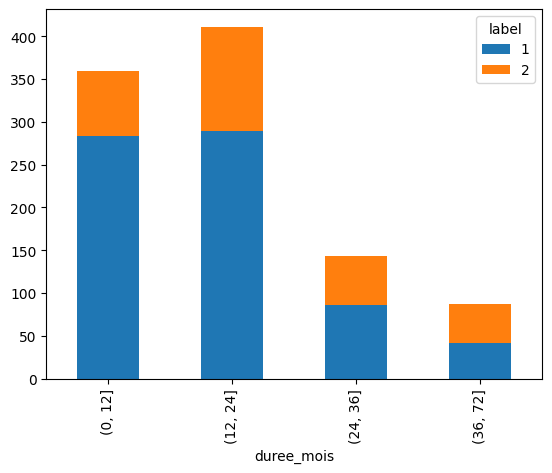

In [15]:
bins = [0,12,24,36 ,72]
df1 = df[["duree_mois", "label"]].copy()
df1["duree_mois"] = pd.cut(df['duree_mois'], bins)
df1.groupby(['duree_mois', 'label']).size().unstack("label").plot.bar(stacked=True)

<Axes: xlabel='montant_credit'>

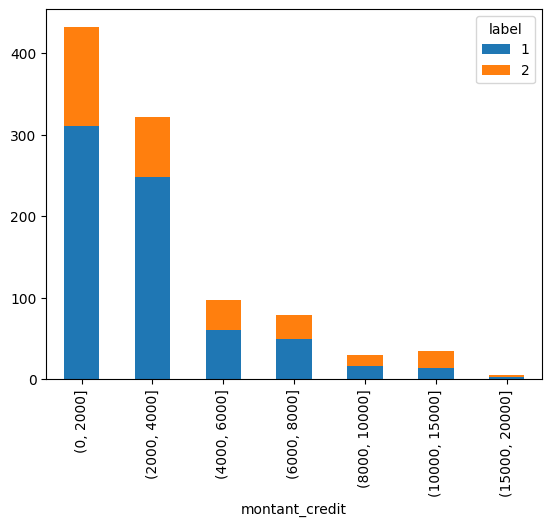

In [16]:
bins = [0,2000,4000,6000,8000,10000,15000,20000]
bank_df1 = df[["montant_credit", "label"]].copy()
bank_df1["montant_credit"] = pd.cut(df['montant_credit'], bins)
bank_df1.groupby(['montant_credit', 'label']).size().unstack("label").plot.bar(stacked=True)

<Axes: ylabel='label'>

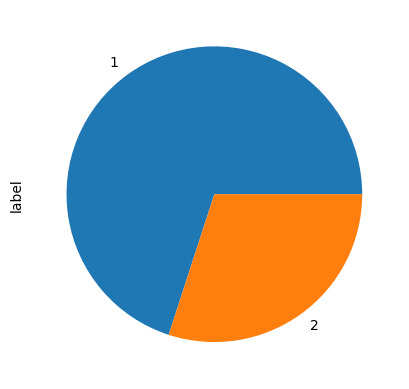

In [17]:
df['label'].value_counts().plot.pie()

In [18]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [19]:
configure_plotly_browser_state()
#------------------------------------------------------------------
trace0 = go.Bar(
            x = df[df["label"]== 1]["label"].value_counts().index.values,
            y = df[df["label"]== 1]["label"].value_counts().values,
            name='Good')

trace1 = go.Bar(
            x = df[df["label"]== 2]["label"].value_counts().index.values,
            y = df[df["label"]== 2]["label"].value_counts().values,
            name='Bad')


data = [trace0, trace1]
layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='Risk Variable'
    ),
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.line.color = "black"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "black"
py.iplot(fig, filename='grouped-bar')

In [20]:
configure_plotly_browser_state()
#-------------------------------------------------------------------------------
df_good = df.loc[df["label"] == 1]['age'].values.tolist()
df_bad = df.loc[df["label"] == 2]['age'].values.tolist()
df_age = df['age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition of age'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

/usr/local/lib/python3.10/dist-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [21]:
configure_plotly_browser_state()
#----------------------------------------------------------------------
#Let's look the Credit Amount column
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df['age'], interval, labels=cats)

# And let's re-create "df_bad" dataframes with "df_good" we created.
df_good = df[df["label"] == 1]
df_bad = df[df["label"] == 2]

#----------------------------------------------------------------------
df['montant_credit']
trace0 = go.Box(
    y=df_good["montant_credit"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(
        color='LightSkyBlue'
    )
)

trace1 = go.Box(
    y=df_bad['montant_credit'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(
        color='DarkSlateGrey'
    )
)

data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Montant du crédit',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

In [22]:
def cat_sexe(x):
  if x in L1:
    return('male')
  else:
    return('female')

L1 = ['A91','A93','A94']
L2 = ['A92','A95']
df['sexe'] = df['status_sexe'].map(cat_sexe)

In [23]:
configure_plotly_browser_state()
#----------------------------------------------------------------------
#First plot
trace0 = go.Bar(
    x = df[df["label"]== 1]["sexe"].value_counts().index.values,
    y = df[df["label"]== 1]["sexe"].value_counts().values,
    name='Good credit'
)

#First plot 2
trace1 = go.Bar(
    x = df[df["label"]== 2]["sexe"].value_counts().index.values,
    y = df[df["label"]== 2]["sexe"].value_counts().values,
    name="Bad Credit"
)

#Second plot
trace2 = go.Box(
    x = df[df["label"]== 1]["sexe"],
    y = df[df["label"]== 1]["montant_credit"],
    name=trace0.name
)

#Second plot 2
trace3 = go.Box(
    x = df[df["label"]== 2]["sexe"],
    y = df[df["label"]== 2]["montant_credit"],
    name=trace1.name
)

data = [trace0, trace1, trace2,trace3]

fig = tls.make_subplots(rows=1, cols=2,
                        subplot_titles=('Sex Count', 'Credit Amount by Sexe'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(height=400, width=800, title='Sex Distribuition', boxmode='group')
py.iplot(fig, filename='sex-subplot')

/usr/local/lib/python3.10/dist-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



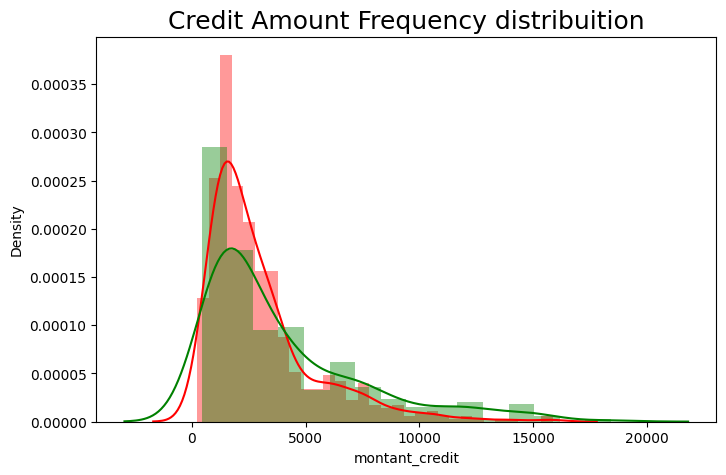

In [24]:
configure_plotly_browser_state()
#----------------------------------------------------------------
#Ploting the good and bad dataframes in distplot
plt.figure(figsize = (8,5))

g= sns.distplot(df_good['montant_credit'], color='red')
g = sns.distplot(df_bad["montant_credit"], color='g')
g.set_title("Credit Amount Frequency distribuition", fontsize=18)
plt.show()

In [25]:
df=df.drop(['sexe','Age_cat'],axis=1)
df

,status_cce,duree_mois,hist_credit,obj,montant_credit,compte_epargne,emplois_depuis,taux_vers_revenu,status_sexe,autres_debits,...,prop,age,plans_vers,log,nbr_credits,travail,nbr_per_charge,tel,trav_etranger,label
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


In [26]:
df1 = df.copy()
for column in df.select_dtypes(include=['object']).columns.to_list():
  df1[column] = pd.factorize(df[column])[0]
df1

,status_cce,duree_mois,hist_credit,obj,montant_credit,compte_epargne,emplois_depuis,taux_vers_revenu,status_sexe,autres_debits,...,prop,age,plans_vers,log,nbr_credits,travail,nbr_per_charge,tel,trav_etranger,label
0,0,6,0,0,1169,0,0,4,0,0,...,0,67,0,0,2,0,1,0,0,1
1,1,48,1,0,5951,1,1,2,1,0,...,0,22,0,0,1,0,1,1,0,2
2,2,12,0,1,2096,1,2,2,0,0,...,0,49,0,0,1,1,2,1,0,1
3,0,42,1,2,7882,1,2,2,0,1,...,1,45,0,1,1,0,2,1,0,1
4,0,24,2,3,4870,1,1,3,0,0,...,2,53,0,1,2,0,2,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,12,1,2,1736,1,2,3,1,0,...,0,31,0,0,1,1,1,1,0,1
996,0,30,1,4,3857,1,1,4,2,0,...,1,40,0,0,1,2,1,0,0,1
997,2,12,1,0,804,1,0,4,0,0,...,3,38,0,0,1,0,1,1,0,1
998,0,45,1,0,1845,1,1,4,0,0,...,2,23,0,1,1,0,1,0,0,2


In [27]:
X = df1.loc[:, df1.columns != 'label'].to_numpy()
Y = df1['label'].to_numpy()

In [28]:
X_numerical = df1[numerical_vars].to_numpy()
X_categorical = df1[categorical_vars].to_numpy()

In [29]:
X_numerical_train, X_numerical_test,Y_train, Y_test = train_test_split(X_numerical, Y, test_size=0.10)

In [30]:
smoteImbOver = SMOTE()
X_numerical_smote,Y_smote = smoteImbOver.fit_resample(X_numerical,Y)
X_numerical_smote.shape, Y_smote.shape
X_numerical_smote_train,X_numerical_smote_test, Y_smote_train,Y_smote_test = train_test_split(X_numerical_smote, Y_smote, test_size=0.10)

In [31]:
ccImbUnder = ClusterCentroids(random_state=42)
X_numerical_cc, Y_cc = ccImbUnder.fit_resample(X_numerical,Y)
X_numerical_cc.shape, Y_cc.shape
X_numerical_cc_train, X_numerical_cc_test, Y_cc_train, Y_cc_test = train_test_split(X_numerical_cc, Y_cc, test_size=0.10)

In [32]:
smoteImbCombine = SMOTEENN()
X_numerical_smoteenn, Y_smoteenn = smoteImbCombine.fit_resample(X_numerical, Y)
X_numerical_smoteenn.shape,Y_smoteenn.shape
X_numerical_smoteenn_train, X_numerical_smoteenn_test, Y_smoteenn_train, Y_smoteenn_test = train_test_split(X_numerical_smoteenn, Y_smoteenn, test_size=0.10)

In [33]:
%%capture
methods = {}
methods['LR'] = {'model': LogisticRegression(), 'results': {}}
methods['LDA'] = {'model': LinearDiscriminantAnalysis(), 'results': {}}
methods['NB'] = {'model': GaussianNB(), 'results': {}}
methods['KNN'] = {'model': KNeighborsClassifier(), 'results': {}}
methods['CART'] = {'model': DecisionTreeClassifier(), 'results': {}}
methods['RF'] = {'model': RandomForestClassifier(), 'results': {}}

accuracy = {}
accuracy['LR'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}
accuracy['LDA'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}
accuracy['NB'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}
accuracy['KNN'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}
accuracy['CART'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}
accuracy['RF'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}

for name, method in methods.items():
  model = method['model']
  kfold = KFold(n_splits=5)
  model.fit(X_numerical_train, Y_train)
  cv_results_original_train = cross_val_score(model, X_numerical_train,Y_train, cv=kfold, scoring='accuracy')
  cv_results_original_test = cross_val_score(model, X_numerical_test, Y_test, cv=kfold, scoring='accuracy')

  model.fit(X_numerical_smote_train, Y_smote_train)
  cv_results_smote_train = cross_val_score(model, X_numerical_smote_train, Y_smote_train, cv=kfold, scoring='accuracy')
  cv_results_smote_test = cross_val_score(model, X_numerical_smote_test, Y_smote_test, cv=kfold, scoring='accuracy')

  model.fit(X_numerical_cc_train, Y_cc_train)
  cv_results_cc_train = cross_val_score(model, X_numerical_cc_train, Y_cc_train, cv=kfold, scoring='accuracy')
  cv_results_cc_test = cross_val_score(model, X_numerical_cc_test, Y_cc_test, cv=kfold, scoring='accuracy')

  model.fit(X_numerical_smoteenn_train, Y_smoteenn_train)
  cv_results_smoteenn_train = cross_val_score(model, X_numerical_smoteenn_train, Y_smoteenn_train, cv=kfold, scoring='accuracy')
  cv_results_smoteenn_test = cross_val_score(model, X_numerical_smoteenn_test, Y_smoteenn_test, cv=kfold, scoring='accuracy')

  method['results']['original'] = {'train': {'mean': cv_results_original_train.mean(), 'max': cv_results_original_train.max(), 'std': cv_results_original_train.std()}, 'test': {'mean': cv_results_original_test.mean(), 'max': cv_results_original_test.max(), 'std': cv_results_original_test.std()}}
  method['results']['smote'] = {'train': {'mean': cv_results_smote_train.mean(), 'max': cv_results_smote_train.max(), 'std': cv_results_smote_train.std()}, 'test': {'mean': cv_results_smote_test.mean(), 'max': cv_results_smote_test.max(), 'std': cv_results_smote_test.std()}}
  method['results']['cc'] = {'train': {'mean': cv_results_cc_train.mean(), 'max': cv_results_cc_train.max(), 'std': cv_results_cc_train.std()}, 'test': {'mean': cv_results_cc_test.mean(), 'max': cv_results_cc_test.max(), 'std': cv_results_cc_test.std()}}
  method['results']['smoteenn'] = {'train': {'mean': cv_results_smoteenn_train.mean(), 'max': cv_results_smoteenn_train.max(), 'std': cv_results_smoteenn_train.std()}, 'test': {'mean': cv_results_smoteenn_test.mean(), 'max': cv_results_smoteenn_test.max(), 'std': cv_results_smoteenn_test.std()}}


  accuracy[name]['original'] = {'train': cv_results_original_train, 'test':cv_results_original_test}
  accuracy[name]['smote'] = {'train': cv_results_smote_train, 'test': cv_results_smote_test}
  accuracy[name]['cc'] = {'train': cv_results_cc_train,  'test': cv_results_cc_test}
  accuracy[name]['smoteenn'] = {'train':cv_results_smoteenn_train, 'test': cv_results_smoteenn_test}

In [34]:
numerical_data_results = pd.DataFrame.from_dict({(i,j,k): methods[i]['results'][j][k]
                  for i in methods.keys()
                  for j in methods[i]['results'].keys()
                  for k in methods[i]['results'][j].keys()},
              orient='index')

numerical_data_results

mean       max       std
LR   original train  0.698889  0.733333  0.022055
              test   0.700000  0.800000  0.063246
     smote    train  0.607143  0.619048  0.016457
              test   0.521429  0.571429  0.042857
     cc       train  0.529630  0.583333  0.049135
              test   0.566667  0.750000  0.143372
     smoteenn train  0.669413  0.766667  0.058853
              test   0.700000  0.800000  0.063246
LDA  original train  0.696667  0.727778  0.018459
              test   0.700000  0.750000  0.031623
     smote    train  0.621429  0.650794  0.025668
              test   0.528571  0.607143  0.057143
     cc       train  0.553704  0.638889  0.067128
              test   0.533333  0.750000  0.154560
     smoteenn train  0.678327  0.766667  0.055850
              test   0.700000  0.800000  0.063246
NB   original train  0.703333  0.733333  0.026200
              test   0.720000  0.800000  0.050990
     smote    train  0.599206  0.634921  0.030942
              test   0.521429  0.607143  0.058029
     cc       train  0.574074  0.648148  0.073842
              test   0.500000  0.666667  0.117851
     smoteenn train  0.647391  0.755556  0.068016
              test   0.800000  0.900000  0.109545
KNN  original train  0.641111  0.650000  0.007536
              test   0.720000  0.800000  0.097980
     smote    train  0.623016  0.682540  0.037979
              test   0.557143  0.714286  0.147427
     cc       train  0.492593  0.509259  0.019772
              test   0.500000  0.666667  0.105409
     smoteenn train  0.870612  0.933333  0.051769
              test   0.740000  0.900000  0.135647
CART original train  0.631111  0.655556  0.014316
              test   0.600000  0.650000  0.044721
     smote    train  0.668254  0.710317  0.032491
              test   0.478571  0.642857  0.094761
     cc       train  0.668519  0.694444  0.018885
              test   0.566667  0.750000  0.133333
     smoteenn train  0.834632  0.888889  0.059482
              test   0.680000  1.000000  0.172047
RF   original train  0.677778  0.716667  0.023307
              test   0.690000  0.750000  0.037417
     smote    train  0.704762  0.726190  0.014763
              test   0.521429  0.642857  0.069985
     cc       train  0.720370  0.768519  0.032288
              test   0.550000  0.750000  0.113039
     smoteenn train  0.863745  0.922222  0.030616
              test   0.720000  1.000000  0.172047

In [35]:
X_categorical_train, X_categorical_test, Y_train, Y_test = train_test_split(X_categorical, Y, test_size=0.15)

In [36]:
smoteImbOver = SMOTE()
X_categorical_smote, Y_smote = smoteImbOver.fit_resample(X_categorical,Y)
X_categorical_smote.shape, Y_smote.shape
X_categorical_smote_train, X_categorical_smote_test, Y_smote_train, Y_smote_test = train_test_split(X_categorical_smote, Y_smote, test_size=0.15)

In [37]:
ccImbUnder = ClusterCentroids(random_state=42)
X_categorical_cc,Y_cc = ccImbUnder.fit_resample(X_categorical,Y)
X_categorical_cc.shape, Y_cc.shape
X_categorical_cc_train, X_categorical_cc_test, Y_cc_train, Y_cc_test = train_test_split(X_categorical_cc, Y_cc, test_size=0.15)

In [38]:
smoteImbCombine = SMOTEENN()
X_categorical_smoteenn, Y_smoteenn = smoteImbCombine.fit_resample(X_categorical, Y)
X_categorical_smoteenn.shape, Y_smoteenn.shape
X_categorical_smoteenn_train, X_categorical_smoteenn_test, Y_smoteenn_train, Y_smoteenn_test = train_test_split(X_categorical_smoteenn, Y_smoteenn, test_size=0.15)

In [39]:
%%capture
methods = {}
methods['LR'] = {'model': LogisticRegression(), 'results': {}}
methods['LDA'] = {'model': LinearDiscriminantAnalysis(), 'results': {}}
methods['KNN'] = {'model': KNeighborsClassifier(), 'results': {}}
methods['CART'] = {'model': DecisionTreeClassifier(), 'results': {}}
methods['RF'] = {'model': RandomForestClassifier(), 'results': {}}
methods['NB'] = {'model': GaussianNB(), 'results': {}}

accuracy = {}
accuracy['LR'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}
accuracy['LDA'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}
accuracy['NB'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}
accuracy['KNN'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}
accuracy['CART'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}
accuracy['RF'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}


for name, method in methods.items():
  model = method['model']
  kfold = KFold(n_splits=10)
  model.fit(X_categorical_train, Y_train)
  cv_results_original_train = cross_val_score(model, X_categorical_train, Y_train, cv=kfold, scoring='accuracy')
  cv_results_original_test = cross_val_score(model, X_categorical_test, Y_test, cv=kfold, scoring='accuracy')

  model.fit(X_categorical_smote_train, Y_smote_train)
  cv_results_smote_train = cross_val_score(model,X_categorical_smote_train, Y_smote_train, cv=kfold, scoring='accuracy')
  cv_results_smote_test = cross_val_score(model, X_categorical_smote_test, Y_smote_test, cv=kfold, scoring='accuracy')

  model.fit(X_categorical_cc_train, Y_cc_train)
  cv_results_cc_train = cross_val_score(model, X_categorical_cc_train, Y_cc_train, cv=kfold, scoring='accuracy')
  cv_results_cc_test = cross_val_score(model, X_categorical_cc_test, Y_cc_test, cv=kfold, scoring='accuracy')

  model.fit(X_categorical_smoteenn_train, Y_smoteenn_train)
  cv_results_smoteenn_train = cross_val_score(model, X_categorical_smoteenn_train, Y_smoteenn_train, cv=kfold, scoring='accuracy')
  cv_results_smoteenn_test = cross_val_score(model, X_categorical_smoteenn_test,Y_smoteenn_test, cv=kfold, scoring='accuracy')

  method['results']['original'] = {'train': {'mean': cv_results_original_train.mean(), 'max': cv_results_original_train.max(), 'std': cv_results_original_train.std()}, 'test': {'mean': cv_results_original_test.mean(), 'max': cv_results_original_test.max(), 'std': cv_results_original_test.std()}}
  method['results']['smote'] = {'train': {'mean': cv_results_smote_train.mean(), 'max': cv_results_smote_train.max(), 'std': cv_results_smote_train.std()}, 'test': {'mean': cv_results_smote_test.mean(), 'max': cv_results_smote_test.max(), 'std': cv_results_smote_test.std()}}
  method['results']['cc'] = {'train': {'mean': cv_results_cc_train.mean(), 'max': cv_results_cc_train.max(), 'std': cv_results_cc_train.std()}, 'test': {'mean': cv_results_cc_test.mean(), 'max': cv_results_cc_test.max(), 'std': cv_results_cc_test.std()}}
  method['results']['smoteenn'] = {'train': {'mean': cv_results_smoteenn_train.mean(), 'max': cv_results_smoteenn_train.max(), 'std': cv_results_smoteenn_train.std()}, 'test': {'mean': cv_results_smoteenn_test.mean(), 'max': cv_results_smoteenn_test.max(), 'std': cv_results_smoteenn_test.std()}}


  accuracy[name]['original'] = {'train': cv_results_original_train, 'test':cv_results_original_test}
  accuracy[name]['smote'] = {'train': cv_results_smote_train, 'test': cv_results_smote_test}
  accuracy[name]['cc'] = {'train': cv_results_cc_train,  'test': cv_results_cc_test}
  accuracy[name]['smoteenn'] = {'train':cv_results_smoteenn_train, 'test': cv_results_smoteenn_test}

In [40]:
categorical_data_results = pd.DataFrame.from_dict({(i,j,k): methods[i]['results'][j][k]
                  for i in methods.keys()
                  for j in methods[i]['results'].keys()
                  for k in methods[i]['results'][j].keys()},
              orient='index')

categorical_data_results

mean       max       std
LR   original train  0.737647  0.788235  0.046183
              test   0.733333  0.866667  0.103280
     smote    train  0.724370  0.815126  0.041476
              test   0.728571  0.809524  0.064065
     cc       train  0.654902  0.745098  0.045733
              test   0.700000  0.888889  0.122222
     smoteenn train  0.872260  0.923077  0.042218
              test   0.791667  0.909091  0.092241
LDA  original train  0.736471  0.788235  0.045625
              test   0.740000  0.866667  0.096379
     smote    train  0.725210  0.815126  0.040485
              test   0.738095  0.809524  0.048795
     cc       train  0.660784  0.725490  0.046442
              test   0.711111  0.888889  0.142292
     smoteenn train  0.880048  0.953846  0.039273
              test   0.781818  0.916667  0.084754
KNN  original train  0.710588  0.811765  0.044706
              test   0.753333  0.933333  0.111754
     smote    train  0.761345  0.798319  0.025819
              test   0.595238  0.714286  0.057341
     cc       train  0.594118  0.745098  0.075458
              test   0.600000  0.888889  0.173561
     smoteenn train  0.905072  0.969231  0.037153
              test   0.712879  0.909091  0.128540
CART original train  0.652941  0.764706  0.055991
              test   0.686667  0.866667  0.111754
     smote    train  0.720168  0.756303  0.028385
              test   0.576190  0.761905  0.113589
     cc       train  0.678431  0.745098  0.049759
              test   0.633333  0.888889  0.140984
     smoteenn train  0.881755  0.921875  0.023568
              test   0.832576  1.000000  0.114012
RF   original train  0.751765  0.800000  0.033462
              test   0.760000  0.866667  0.074237
     smote    train  0.802521  0.857143  0.031499
              test   0.733333  0.857143  0.095713
     cc       train  0.737255  0.803922  0.034187
              test   0.733333  0.888889  0.101835
     smoteenn train  0.925264  0.969231  0.027831
              test   0.887121  1.000000  0.115810
NB   original train  0.698824  0.788235  0.049691
              test   0.673333  0.866667  0.182452
     smote    train  0.652941  0.722689  0.047840
              test   0.695238  0.857143  0.120844
     cc       train  0.680392  0.725490  0.045607
              test   0.633333  0.777778  0.149485
     smoteenn train  0.844327  0.937500  0.053974
              test   0.678788  0.909091  0.192317

In [41]:
X_train, X_test,Y_train, Y_test = train_test_split(X,Y, test_size=0.15)

In [42]:
smoteImbOver = SMOTE()
X_smote, Y_smote = smoteImbOver.fit_resample(X,Y)
X_smote.shape, Y_smote.shape
X_smote_train, X_smote_test, Y_smote_train, Y_smote_test = train_test_split(X_smote, Y_smote, test_size=0.15)

In [43]:
ccImbUnder = ClusterCentroids(random_state=42)
X_cc, Y_cc = ccImbUnder.fit_resample(X,Y)
X_cc.shape,Y_cc.shape
X_cc_train,X_cc_test,Y_cc_train, Y_cc_test = train_test_split(X_cc,Y_cc, test_size=0.15)

In [44]:
smoteImbCombine = SMOTEENN()
X_smoteenn, Y_smoteenn = smoteImbCombine.fit_resample(X,Y)
X_smoteenn.shape, Y_smoteenn.shape
X_smoteenn_train, X_smoteenn_test, Y_smoteenn_train, Y_smoteenn_test = train_test_split(X_smoteenn, Y_smoteenn, test_size=0.15)

In [45]:
%%capture
methods = {}
methods['LR'] = {'model': LogisticRegression(), 'results': {}}
methods['LDA'] = {'model': LinearDiscriminantAnalysis(), 'results': {}}
methods['KNN'] = {'model': KNeighborsClassifier(), 'results': {}}
methods['CART'] = {'model': DecisionTreeClassifier(), 'results': {}}
methods['RF'] = {'model': RandomForestClassifier(), 'results': {}}
methods['NB'] = {'model': GaussianNB(), 'results': {}}


accuracy = {}
accuracy['LR'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}
accuracy['LDA'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}
accuracy['NB'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}
accuracy['KNN'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}
accuracy['CART'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}
accuracy['RF'] = {'original':{},'smote':{},'cc':{},'smoteen':{}}

for name, method in methods.items():
  model = method['model']
  kfold = KFold(n_splits=10)
  model.fit(X_train, Y_train)
  cv_results_original_train = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
  cv_results_original_test = cross_val_score(model, X_test,Y_test, cv=kfold, scoring='accuracy')

  model.fit(X_smote_train, Y_smote_train)
  cv_results_smote_train = cross_val_score(model, X_smote_train, Y_smote_train, cv=kfold, scoring='accuracy')
  cv_results_smote_test = cross_val_score(model, X_smote_test,Y_smote_test, cv=kfold, scoring='accuracy')

  model.fit(X_cc_train, Y_cc_train)
  cv_results_cc_train = cross_val_score(model, X_cc_train,Y_cc_train, cv=kfold, scoring='accuracy')
  cv_results_cc_test = cross_val_score(model, X_cc_test,Y_cc_test, cv=kfold, scoring='accuracy')

  model.fit(X_smoteenn_train, Y_smoteenn_train)
  cv_results_smoteenn_train = cross_val_score(model,X_smoteenn_train, Y_smoteenn_train, cv=kfold, scoring='accuracy')
  cv_results_smoteenn_test = cross_val_score(model, X_smoteenn_test, Y_smoteenn_test, cv=kfold, scoring='accuracy')

  method['results']['original'] = {'train': {'mean': cv_results_original_train.mean(), 'max': cv_results_original_train.max(), 'std': cv_results_original_train.std()}, 'test': {'mean': cv_results_original_test.mean(), 'max': cv_results_original_test.max(), 'std': cv_results_original_test.std()}}
  method['results']['smote'] = {'train': {'mean': cv_results_smote_train.mean(), 'max': cv_results_smote_train.max(), 'std': cv_results_smote_train.std()}, 'test': {'mean': cv_results_smote_test.mean(), 'max': cv_results_smote_test.max(), 'std': cv_results_smote_test.std()}}
  method['results']['cc'] = {'train': {'mean': cv_results_cc_train.mean(), 'max': cv_results_cc_train.max(), 'std': cv_results_cc_train.std()}, 'test': {'mean': cv_results_cc_test.mean(), 'max': cv_results_cc_test.max(), 'std': cv_results_cc_test.std()}}
  method['results']['smoteenn'] = {'train': {'mean': cv_results_smoteenn_train.mean(), 'max': cv_results_smoteenn_train.max(), 'std': cv_results_smoteenn_train.std()}, 'test': {'mean': cv_results_smoteenn_test.mean(), 'max': cv_results_smoteenn_test.max(), 'std': cv_results_smoteenn_test.std()}}

  accuracy[name]['original'] = {'train': cv_results_original_train, 'test':cv_results_original_test}
  accuracy[name]['smote'] = {'train': cv_results_smote_train, 'test': cv_results_smote_test}
  accuracy[name]['cc'] = {'train': cv_results_cc_train,  'test': cv_results_cc_test}
  accuracy[name]['smoteenn'] = {'train':cv_results_smoteenn_train, 'test': cv_results_smoteenn_test}

In [46]:
all_data_results = pd.DataFrame.from_dict({(i,j,k): methods[i]['results'][j][k]
                  for i in methods.keys()
                  for j in methods[i]['results'].keys()
                  for k in methods[i]['results'][j].keys()},
              orient='index')
all_data_results

mean       max       std
LR   original train  0.738824  0.788235  0.034820
              test   0.693333  0.933333  0.104137
     smote    train  0.742017  0.789916  0.033413
              test   0.666667  0.761905  0.095238
     cc       train  0.696078  0.823529  0.056998
              test   0.688889  0.888889  0.138778
     smoteenn train  0.805110  0.926829  0.084761
              test   0.864286  1.000000  0.132721
LDA  original train  0.743529  0.788235  0.037129
              test   0.660000  0.800000  0.086667
     smote    train  0.752101  0.806723  0.041552
              test   0.666667  0.857143  0.108588
     cc       train  0.688235  0.784314  0.055770
              test   0.733333  0.888889  0.123728
     smoteenn train  0.795412  0.902439  0.067778
              test   0.835714  1.000000  0.122631
KNN  original train  0.680000  0.752941  0.037867
              test   0.606667  0.733333  0.075719
     smote    train  0.635294  0.739496  0.044972
              test   0.471429  0.619048  0.096304
     cc       train  0.470588  0.627451  0.069046
              test   0.544444  0.777778  0.175330
     smoteenn train  0.882985  0.976190  0.066251
              test   0.741071  1.000000  0.187500
CART original train  0.690588  0.764706  0.046779
              test   0.720000  0.866667  0.102415
     smote    train  0.731933  0.781513  0.032208
              test   0.638095  0.761905  0.080249
     cc       train  0.717647  0.803922  0.058954
              test   0.744444  0.888889  0.111665
     smoteenn train  0.778513  0.829268  0.057383
              test   0.742857  1.000000  0.152822
RF   original train  0.763529  0.788235  0.020680
              test   0.706667  0.933333  0.143604
     smote    train  0.815966  0.882353  0.043899
              test   0.757143  0.857143  0.058126
     cc       train  0.841176  0.901961  0.042464
              test   0.766667  0.888889  0.135628
     smoteenn train  0.827062  0.904762  0.063367
              test   0.848214  1.000000  0.078348
NB   original train  0.729412  0.764706  0.028333
              test   0.720000  0.933333  0.110755
     smote    train  0.748739  0.815126  0.035344
              test   0.680952  0.857143  0.100000
     cc       train  0.735294  0.843137  0.069185
              test   0.700000  1.000000  0.179505
     smoteenn train  0.785772  0.853659  0.045122
              test   0.698214  0.857143  0.083165

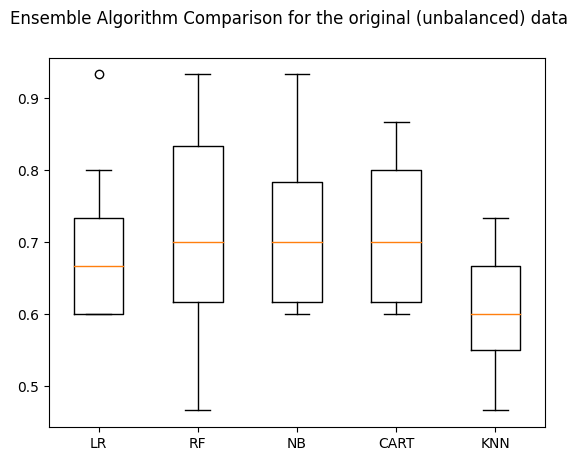

In [47]:
from matplotlib import pyplot
fig = pyplot.figure()
l=[accuracy['LR']['original']['test'],accuracy['RF']['original']['test'],accuracy['NB']['original']['test'],accuracy['CART']['original']['test']]
l=l+[accuracy['KNN']['original']['test']]
fig.suptitle('Ensemble Algorithm Comparison for the original (unbalanced) data')
ax = fig.add_subplot(111)
pyplot.boxplot(l)
ax.set_xticklabels(['LR','RF','NB','CART','KNN'])
pyplot.show()

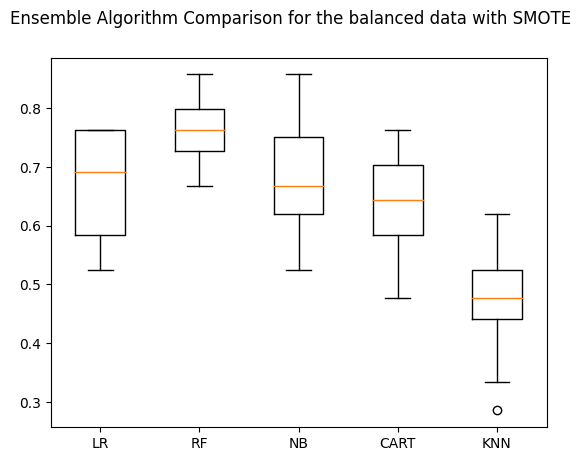

In [48]:
from matplotlib import pyplot
fig = pyplot.figure()
l=[accuracy['LR']['smote']['test'],accuracy['RF']['smote']['test'],accuracy['NB']['smote']['test'],accuracy['CART']['smote']['test']]
l=l+[accuracy['KNN']['smote']['test']]
fig.suptitle('Ensemble Algorithm Comparison for the balanced data with SMOTE')
ax = fig.add_subplot(111)
pyplot.boxplot(l)
ax.set_xticklabels(['LR','RF','NB','CART','KNN'])
pyplot.show()

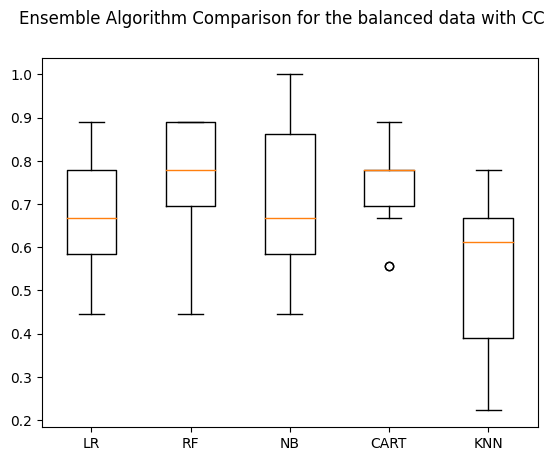

In [49]:
from matplotlib import pyplot
fig = pyplot.figure()
l=[accuracy['LR']['cc']['test'],accuracy['RF']['cc']['test'],accuracy['NB']['cc']['test'],accuracy['CART']['cc']['test']]
l=l+[accuracy['KNN']['cc']['test']]
fig.suptitle('Ensemble Algorithm Comparison for the balanced data with CC')
ax = fig.add_subplot(111)
pyplot.boxplot(l)
ax.set_xticklabels(['LR','RF','NB','CART','KNN'])
pyplot.show()

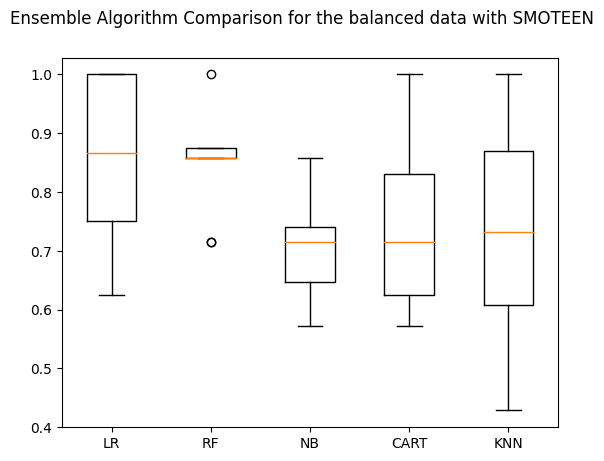

In [50]:
from matplotlib import pyplot
fig = pyplot.figure()
l=[accuracy['LR']['smoteenn']['test'],accuracy['RF']['smoteenn']['test'],accuracy['NB']['smoteenn']['test'],accuracy['CART']['smoteenn']['test']]
l=l+[accuracy['KNN']['smoteenn']['test']]
fig.suptitle('Ensemble Algorithm Comparison for the balanced data with SMOTEEN')
ax = fig.add_subplot(111)
pyplot.boxplot(l)
ax.set_xticklabels(['LR','RF','NB','CART','KNN'])
pyplot.show()

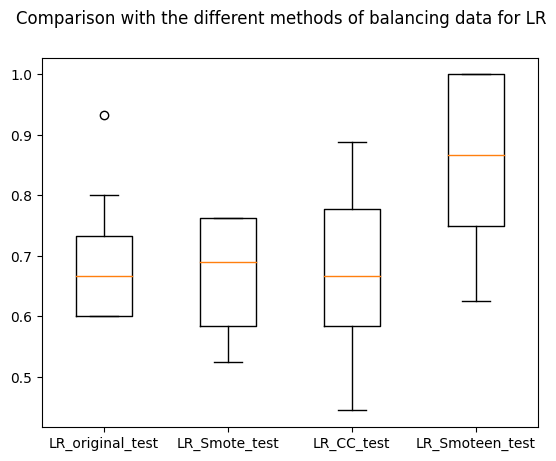

In [51]:
# Compare Algorithms
from matplotlib import pyplot
fig = pyplot.figure()
l=[]
l=l+[accuracy['LR']['original']['test'],accuracy['LR']['smote']['test'],accuracy['LR']['cc']['test'],accuracy['LR']['smoteenn']['test']]
fig.suptitle('Comparison with the different methods of balancing data for LR')
ax = fig.add_subplot(111)
pyplot.boxplot(l)
ax.set_xticklabels(['LR_original_test','LR_Smote_test','LR_CC_test','LR_Smoteen_test'])
pyplot.show()

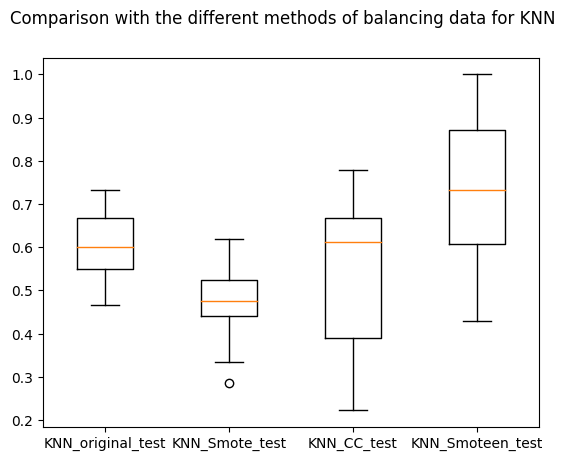

In [52]:
from matplotlib import pyplot
fig = pyplot.figure()
l=[]
l=l+[accuracy['KNN']['original']['test'],accuracy['KNN']['smote']['test'],accuracy['KNN']['cc']['test'],accuracy['KNN']['smoteenn']['test']]
fig.suptitle('Comparison with the different methods of balancing data for KNN')
ax = fig.add_subplot(111)
pyplot.boxplot(l)
ax.set_xticklabels(['KNN_original_test','KNN_Smote_test','KNN_CC_test','KNN_Smoteen_test'])
pyplot.show()

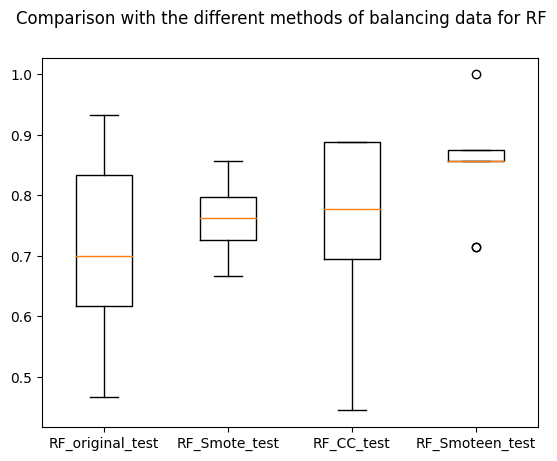

In [53]:
from matplotlib import pyplot
fig = pyplot.figure()
l=[]
l=l+[accuracy['RF']['original']['test'],accuracy['RF']['smote']['test'],accuracy['RF']['cc']['test'],accuracy['RF']['smoteenn']['test']]
fig.suptitle('Comparison with the different methods of balancing data for RF')
ax = fig.add_subplot(111)
pyplot.boxplot(l)
ax.set_xticklabels(['RF_original_test','RF_Smote_test','RF_CC_test','RF_Smoteen_test'])
pyplot.show()

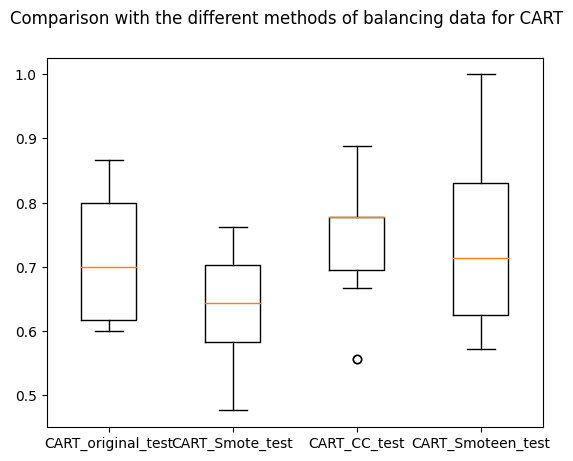

In [54]:
from matplotlib import pyplot
fig = pyplot.figure()
l=[]
l=l+[accuracy['CART']['original']['test'],accuracy['CART']['smote']['test'],accuracy['CART']['cc']['test'],accuracy['CART']['smoteenn']['test']]
fig.suptitle('Comparison with the different methods of balancing data for CART')
ax = fig.add_subplot(111)
pyplot.boxplot(l)
ax.set_xticklabels(['CART_original_test','CART_Smote_test','CART_CC_test','CART_Smoteen_test'])
pyplot.show()

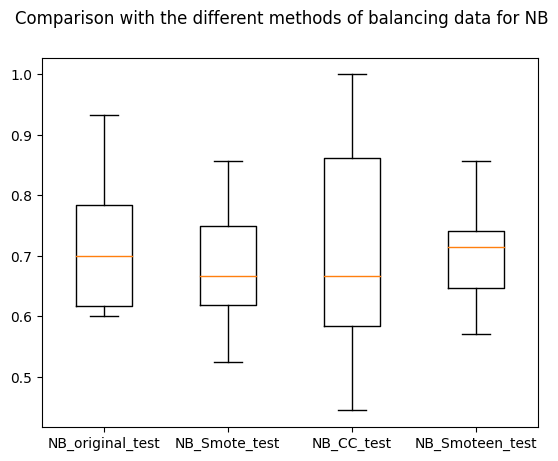

In [55]:
from matplotlib import pyplot
fig = pyplot.figure()
l=[]
l=l+[accuracy['NB']['original']['test'],accuracy['NB']['smote']['test'],accuracy['NB']['cc']['test'],accuracy['NB']['smoteenn']['test']]
fig.suptitle('Comparison with the different methods of balancing data for NB')
ax = fig.add_subplot(111)
pyplot.boxplot(l)
ax.set_xticklabels(['NB_original_test','NB_Smote_test','NB_CC_test','NB_Smoteen_test'])
pyplot.show()

AB: 0.747059 (0.033379)
GBM: 0.755294 (0.040345)
ET: 0.748235 (0.030769)
SVM: 0.714118 (0.062041)
LDA: 0.737647 (0.041777)


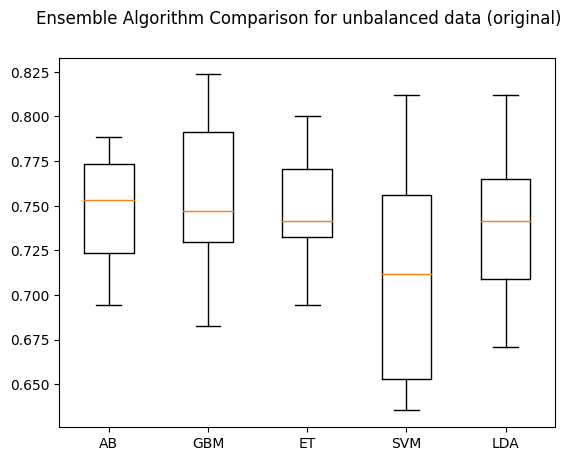

In [169]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
ensembles.append(('SVM', SVC()))
ensembles.append(('LDA', LinearDiscriminantAnalysis()))
results = []
names = []
num_folds = 10
seed = 7
scoring = 'accuracy'
for name, model in ensembles:
	kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Ensemble Algorithm Comparison for unbalanced data (original)')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

AB: 0.846690 (0.045108)
GBM: 0.887979 (0.050360)
ET: 0.837050 (0.040548)
SVM: 0.647096 (0.055358)
LDA: 0.793206 (0.061860)


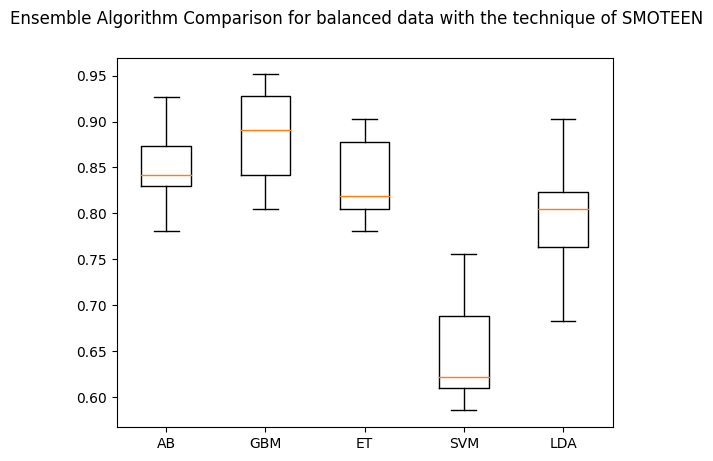

In [57]:

ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
ensembles.append(('SVM', SVC()))
ensembles.append(('LDA', LinearDiscriminantAnalysis()))
results = []
names = []
num_folds = 10
seed = 7
scoring = 'accuracy'
for name, model in ensembles:
	kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
	cv_results = cross_val_score(model,X_smoteenn_train, Y_smoteenn_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Ensemble Algorithm Comparison for balanced data with the technique of SMOTEEN')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

AB: 0.759664 (0.037806)
GBM: 0.783193 (0.030018)
ET: 0.821008 (0.031001)
SVM: 0.559664 (0.033020)
LDA: 0.749580 (0.030944)


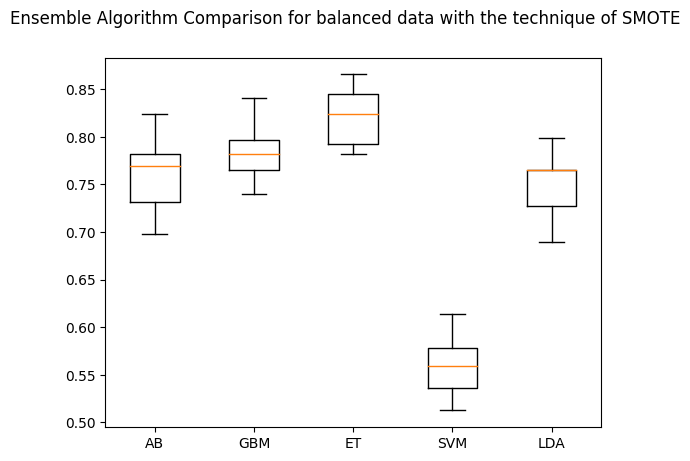

In [58]:


ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
ensembles.append(('SVM', SVC()))
ensembles.append(('LDA', LinearDiscriminantAnalysis()))
results = []
names = []
num_folds = 10
seed = 7
scoring = 'accuracy'
for name, model in ensembles:
	kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
	cv_results = cross_val_score(model,X_smote_train, Y_smote_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Ensemble Algorithm Comparison for balanced data with the technique of SMOTE')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

AB: 0.823529 (0.059474)
GBM: 0.833333 (0.054233)
ET: 0.833333 (0.049020)
Linear SVM: 0.672549 (0.077470)
Non Linear SVM : 0.552941 (0.067241)
LDA: 0.692157 (0.083212)


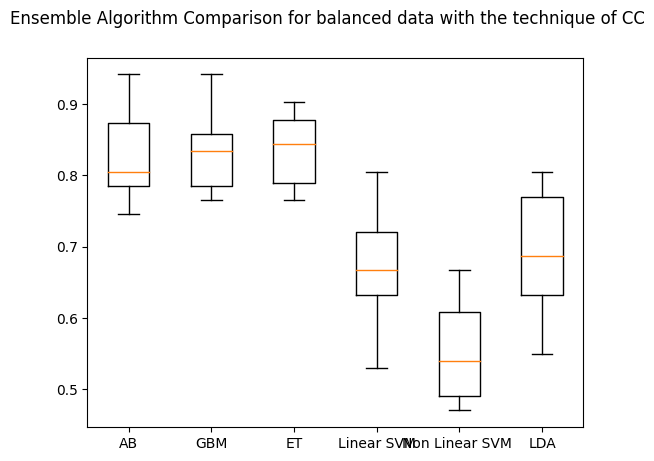

In [ ]:
from sklearn.svm import LinearSVC
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
ensembles.append(('Linear SVM', SVC(kernel='linear')))
ensembles.append(('Non Linear SVM ',SVC(kernel='rbf') ))
ensembles.append(('LDA', LinearDiscriminantAnalysis()))
results = []
names = []
num_folds = 10
seed = 7
scoring = 'accuracy'
for name, model in ensembles:
	kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
	cv_results = cross_val_score(model,X_cc_train, Y_cc_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Ensemble Algorithm Comparison for balanced data with the technique of CC')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

#Random forest

In [183]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from sklearn.metrics import f1_score as f1
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [184]:
def print_roc_auc(classifier,X_test,Y_test):
    y_scores = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [185]:
def rf_model(X_train, Y_train,X_test,Y_test):
    random_forest = RandomForestClassifier( random_state = 100)
    rf=random_forest.fit(X_train, Y_train)
    Y_test_pred=rf.predict(X_test)
    confusion_matrixx= confusion_matrix(Y_test, Y_test_pred)
    total=sum(sum(confusion_matrixx))
    sensitivity_recall = confusion_matrixx[0,0]/(confusion_matrixx[0,0]+confusion_matrixx[1,0])
    print('Sensitivity_recall : ',sensitivity_recall )
    Specificity = confusion_matrixx[1,1]/(confusion_matrixx[1,1]+confusion_matrixx[0,1])
    print('Specificity: ', Specificity)
    precision = confusion_matrixx[0,0]/(confusion_matrixx[0,0]+confusion_matrixx[0,1])
    print('Precision: ', precision)
    accuracy =(confusion_matrixx[0,0]+confusion_matrixx[1,1])/(confusion_matrixx[0,0]+confusion_matrixx[0,1]+confusion_matrixx[1,0]+confusion_matrixx[1,1])
    print('Accuracy: ', accuracy)
    print('NMI: ',nmi(Y_test,Y_test_pred))
    print("Recall:",recall_score(Y_test,Y_test_pred))
    print("F-score: ", f1(Y_test,Y_test_pred))
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(confusion_matrixx), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

Sensitivity_recall :  0.7723577235772358
Specificity:  0.8148148148148148
Precision:  0.95
Accuracy:  0.78
NMI:  0.1993067273913438
Recall: 0.95
F-score:  0.852017937219731


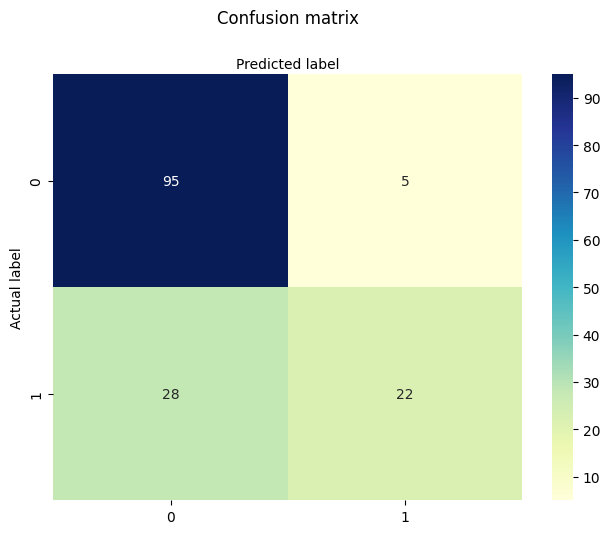

In [186]:
rf_model(X_train, Y_train,X_test,Y_test)

Sensitivity_recall :  0.8125
Specificity:  0.7894736842105263
Precision:  0.7647058823529411
Accuracy:  0.8
NMI:  0.2788999996165948
Recall: 0.7647058823529411
F-score:  0.787878787878788


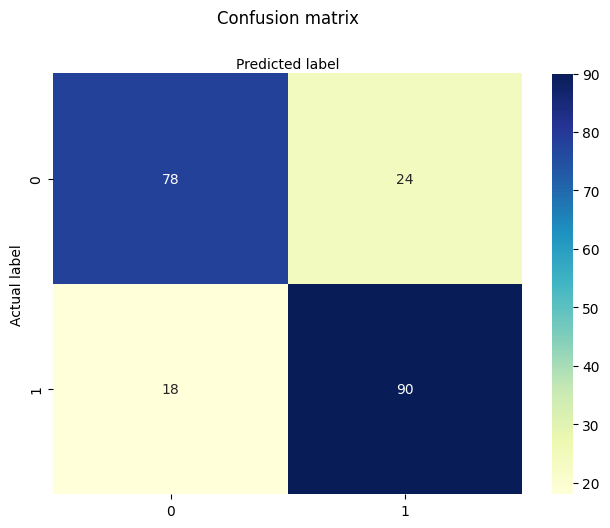

In [124]:
rf_model(X_smote_train, Y_smote_train,X_smote_test,Y_smote_test)

Sensitivity_recall :  0.7804878048780488
Specificity:  0.7346938775510204
Precision:  0.7111111111111111
Accuracy:  0.7555555555555555
NMI:  0.2002595232010804
Recall: 0.7111111111111111
F-score:  0.7441860465116279


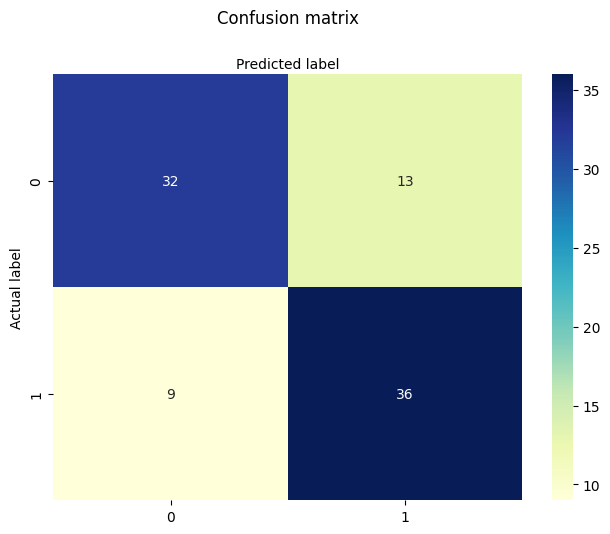

In [125]:
rf_model(X_cc_train, Y_cc_train,X_cc_test,Y_cc_test)

Sensitivity_recall :  0.875
Specificity:  0.9387755102040817
Precision:  0.875
Accuracy:  0.9178082191780822
NMI:  0.5602882435096189
Recall: 0.875
F-score:  0.875


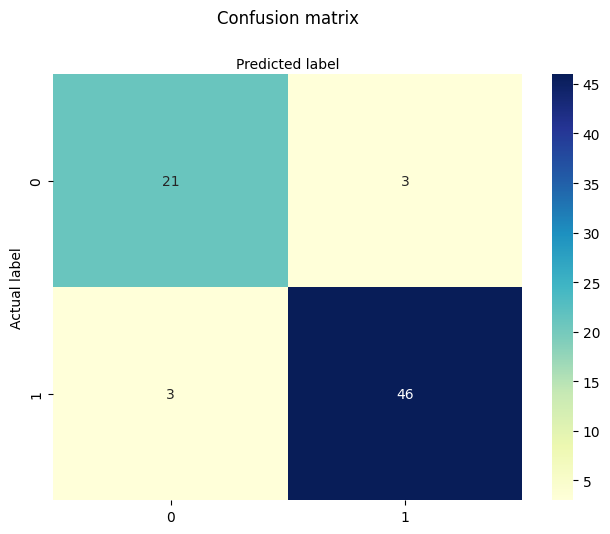

In [126]:
rf_model(X_smoteenn_train, Y_smoteenn_train,X_smoteenn_test,Y_smoteenn_test)

#KNN

In [73]:
def get_K(X_train, Y_train,X_test,Y_test):
      k_range = list(range(1, 33))
      scores = []
      for k in k_range:
          knn = KNeighborsClassifier(n_neighbors=k)
          knn.fit(X_train, Y_train)
          y_pred_k = knn.predict(X_test)
          scores.append(accuracy_score(Y_test, y_pred_k))
      # plot the relationship between K and testing accuracy
      plt.plot(k_range, scores)
      plt.xlabel('Value of K for KNN')
      plt.ylabel('Testing Accuracy')

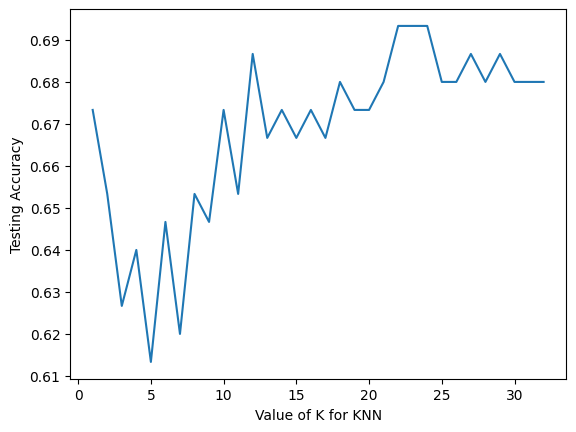

In [92]:
get_K(X_train, Y_train,X_test,Y_test)

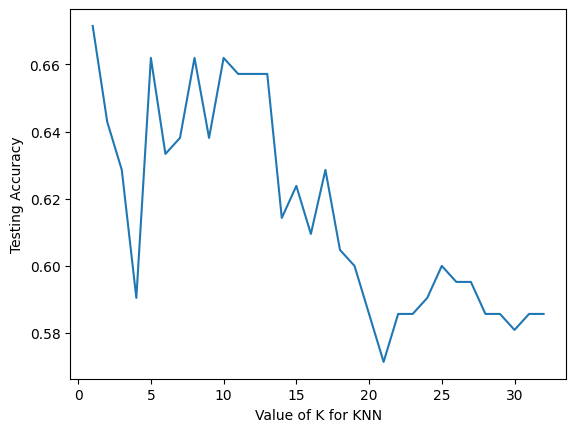

In [139]:
get_K(X_smote_train, Y_smote_train,X_smote_test,Y_smote_test)

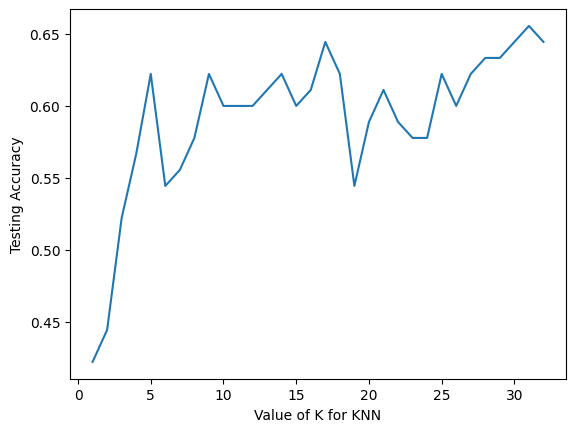

In [140]:
get_K(X_cc_train, Y_cc_train,X_cc_test,Y_cc_test)

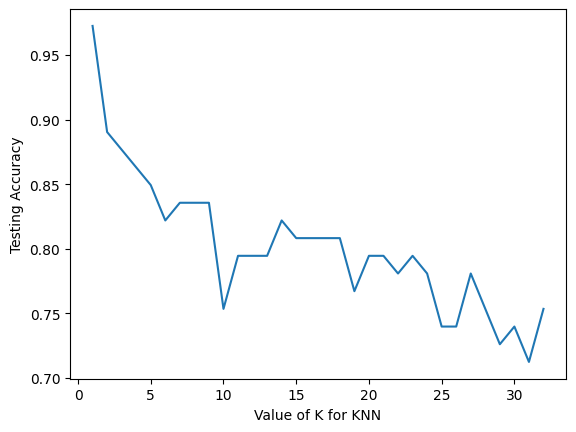

In [141]:
get_K(X_smoteenn_train, Y_smoteenn_train,X_smoteenn_test,Y_smoteenn_test)

In [117]:
def knn_model(X_train, Y_train ,X_test,Y_test,k):
      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(X_train, Y_train)
      y_pred_kn = knn.predict(X_test)
      c=confusion_matrix(Y_test, y_pred_kn)
      print(accuracy_score(Y_test, y_pred_kn))
      print("Accuracy:",accuracy_score(Y_test, y_pred_kn))
      print("Precision:",precision_score(Y_test, y_pred_kn))
      print("Recall:",recall_score(Y_test, y_pred_kn))
      print('NMI: ',nmi(Y_test,y_pred_kn))
      print("F-score: ", f1(Y_test,y_pred_kn))
      class_names=[0,1] # name  of classes
      fig, ax = plt.subplots()
      tick_marks = np.arange(len(class_names))
      plt.xticks(tick_marks, class_names)
      plt.yticks(tick_marks, class_names)
      # create heatmap
      sns.heatmap(pd.DataFrame(c), annot=True, cmap="YlGnBu" ,fmt='g')
      ax.xaxis.set_label_position("top")
      plt.tight_layout()
      plt.title('Confusion matrix', y=1.1)
      plt.ylabel('Actual label')
      plt.xlabel('Predicted label')

0.6933333333333334
Accuracy: 0.6933333333333334
Precision: 0.6875
Recall: 0.99
NMI:  0.05531374323271633
F-score:  0.8114754098360656


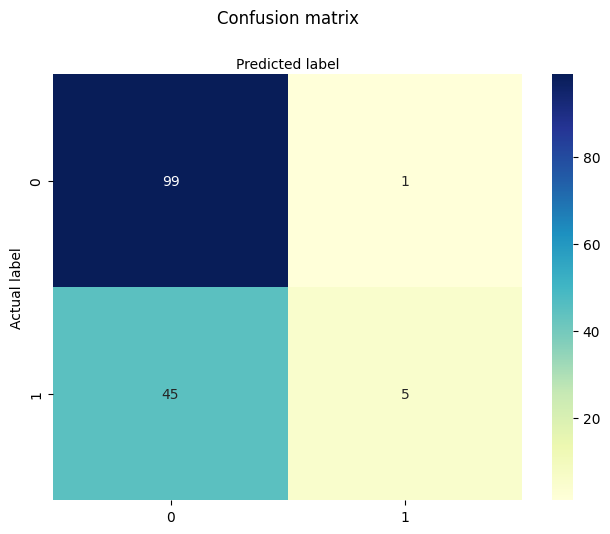

In [118]:
knn_model(X_train, Y_train ,X_test,Y_test,22)

0.5857142857142857
Accuracy: 0.5857142857142857
Precision: 0.5728155339805825
Recall: 0.5784313725490197
NMI:  0.0212000519937608
F-score:  0.575609756097561


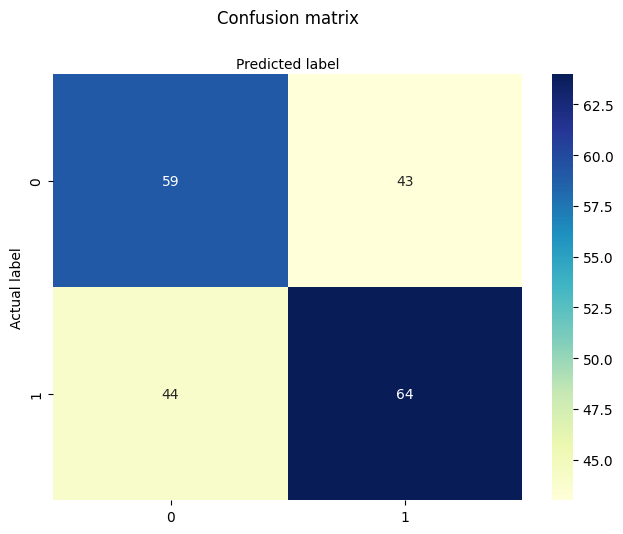

In [119]:
knn_model(X_smote_train, Y_smote_train ,X_smote_test,Y_smote_test,22)

0.7808219178082192
Accuracy: 0.7808219178082192
Precision: 0.6538461538461539
Recall: 0.7083333333333334
NMI:  0.20646469918740215
F-score:  0.68


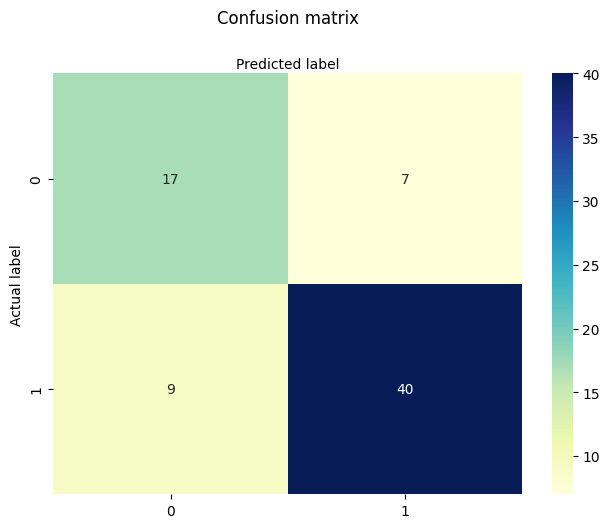

In [120]:
knn_model(X_smoteenn_train, Y_smoteenn_train ,X_smoteenn_test,Y_smoteenn_test,22)

0.5888888888888889
Accuracy: 0.5888888888888889
Precision: 0.58
Recall: 0.6444444444444445
NMI:  0.023318284042742422
F-score:  0.6105263157894737


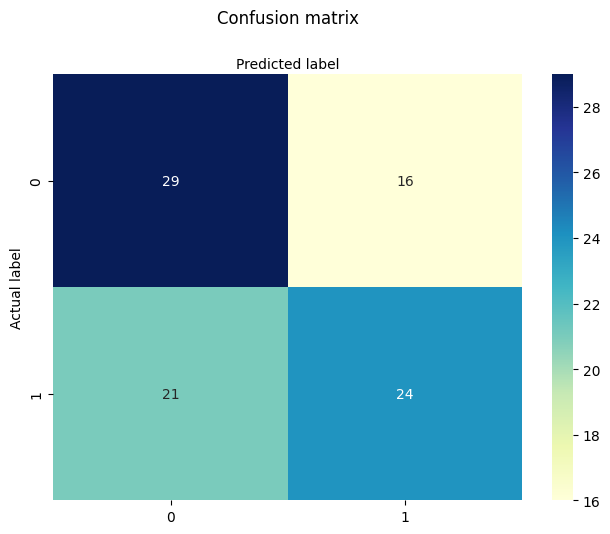

In [121]:
knn_model(X_cc_train, Y_cc_train ,X_cc_test,Y_cc_test,22)

#Naive Bayes

In [112]:
def Naive_bayes(X_train,Y_train,X_test,Y_test):
      GNB = GaussianNB()
      # Fitting with train data
      model = GNB.fit(X_train, Y_train)
      print("Primitive error evaluation accuracy score: ", model.score(X_train, Y_train))
      y_pred_nb = model.predict(X_test)
      c=confusion_matrix(Y_test, y_pred_nb)
      print("Test predict accuracy score: ", accuracy_score(Y_test,y_pred_nb),"\n")
      #print("Confusion Matrix: \n", confusion_matrix(Y_test, y_pred_nb),"\n")
      class_names=[0,1] # name  of classes
      fig, ax = plt.subplots()
      tick_marks = np.arange(len(class_names))
      plt.xticks(tick_marks, class_names)
      plt.yticks(tick_marks, class_names)
      # create heatmap
      sns.heatmap(pd.DataFrame(c), annot=True, cmap="YlGnBu" ,fmt='g')
      ax.xaxis.set_label_position("top")
      plt.tight_layout()
      plt.title('Confusion matrix', y=1.1)
      plt.ylabel('Actual label')
      plt.xlabel('Predicted label')
      print("Classification report according to Test prediction: \n", classification_report(Y_test, y_pred_nb))
      print("Accuracy:",accuracy_score(Y_test, y_pred_nb))
      print("Precision:",precision_score(Y_test, y_pred_nb))
      print("Recall:",recall_score(Y_test, y_pred_nb))
      print('NMI: ',nmi(Y_test,y_pred_nb))
      print("F-score: ", f1(Y_test,y_pred_nb))

Primitive error evaluation accuracy score:  0.7423529411764705
Test predict accuracy score:  0.7733333333333333 

Classification report according to Test prediction: 
               precision    recall  f1-score   support

           1       0.81      0.86      0.83       100
           2       0.68      0.60      0.64        50

    accuracy                           0.77       150
   macro avg       0.75      0.73      0.74       150
weighted avg       0.77      0.77      0.77       150

Accuracy: 0.7733333333333333
Precision: 0.8113207547169812
Recall: 0.86
NMI:  0.17847035283647142
F-score:  0.8349514563106797


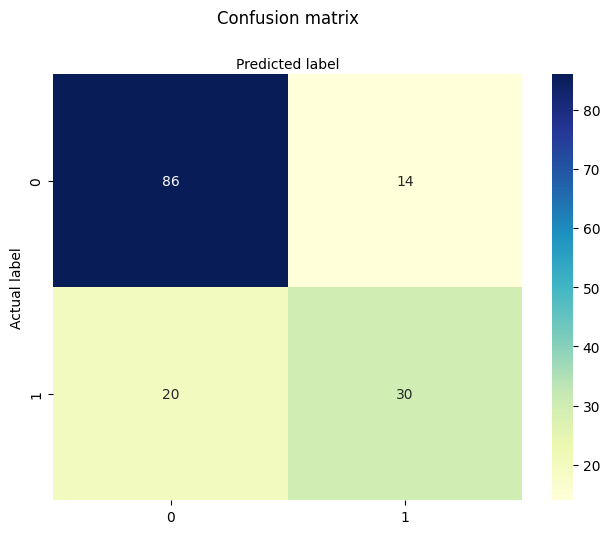

In [113]:
Naive_bayes(X_train,Y_train,X_test,Y_test)

Primitive error evaluation accuracy score:  0.7563025210084033
Test predict accuracy score:  0.7095238095238096 

Classification report according to Test prediction: 
               precision    recall  f1-score   support

           1       0.75      0.60      0.67       102
           2       0.68      0.81      0.74       108

    accuracy                           0.71       210
   macro avg       0.72      0.71      0.70       210
weighted avg       0.72      0.71      0.71       210

Accuracy: 0.7095238095238096
Precision: 0.7530864197530864
Recall: 0.5980392156862745
NMI:  0.13694527190759695
F-score:  0.6666666666666667


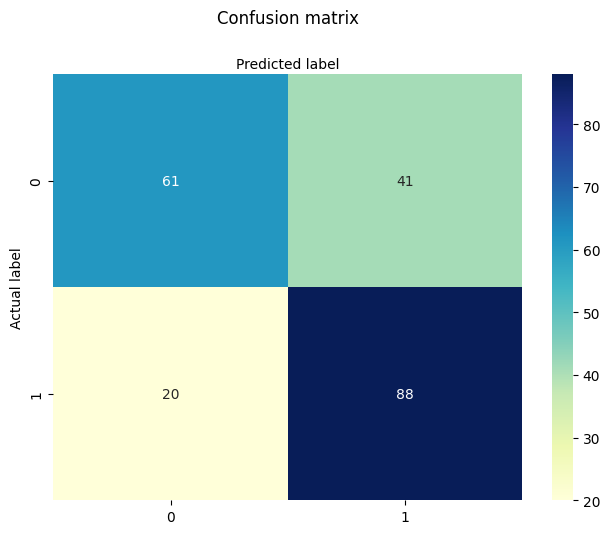

In [114]:
Naive_bayes(X_smote_train,Y_smote_train,X_smote_test,Y_smote_test)

Primitive error evaluation accuracy score:  0.8150851581508516
Test predict accuracy score:  0.8082191780821918 

Classification report according to Test prediction: 
               precision    recall  f1-score   support

           1       0.71      0.71      0.71        24
           2       0.86      0.86      0.86        49

    accuracy                           0.81        73
   macro avg       0.78      0.78      0.78        73
weighted avg       0.81      0.81      0.81        73

Accuracy: 0.8082191780821918
Precision: 0.7083333333333334
Recall: 0.7083333333333334
NMI:  0.25195314325966844
F-score:  0.7083333333333334


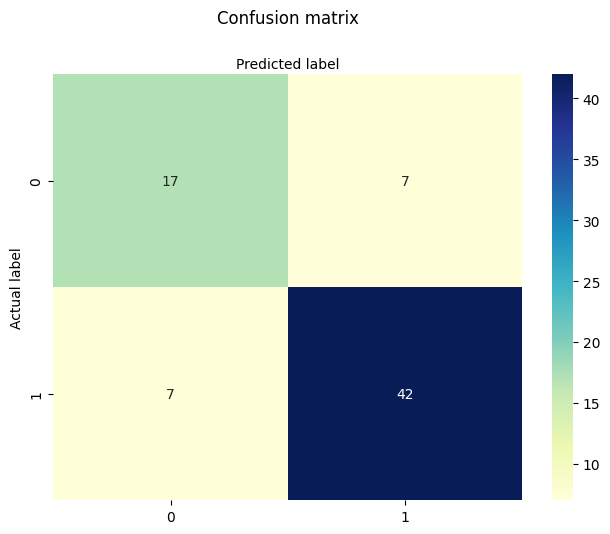

In [115]:
Naive_bayes(X_smoteenn_train,Y_smoteenn_train,X_smoteenn_test,Y_smoteenn_test)

Primitive error evaluation accuracy score:  0.7431372549019608
Test predict accuracy score:  0.6555555555555556 

Classification report according to Test prediction: 
               precision    recall  f1-score   support

           1       0.65      0.67      0.66        45
           2       0.66      0.64      0.65        45

    accuracy                           0.66        90
   macro avg       0.66      0.66      0.66        90
weighted avg       0.66      0.66      0.66        90

Accuracy: 0.6555555555555556
Precision: 0.6521739130434783
Recall: 0.6666666666666666
NMI:  0.07104248181372987
F-score:  0.6593406593406593


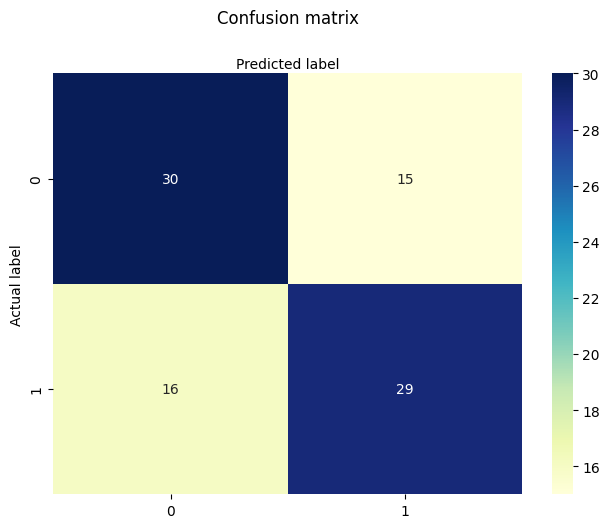

In [116]:
Naive_bayes(X_cc_train,Y_cc_train,X_cc_test,Y_cc_test)

#Logistic regression

In [167]:
from sklearn.linear_model import LogisticRegression
def LR_model(X_train,Y_train,X_test,Y_test):
      # instantiate the model (using the default parameters)
      logreg = LogisticRegression()
      # fit the model with data
      logreg.fit(X_train,Y_train)
      y_pred_log=logreg.predict(X_test)
      cnf_matrix =confusion_matrix(Y_test, y_pred_log)
      class_names=[0,1] # name  of classes
      fig, ax = plt.subplots()
      tick_marks = np.arange(len(class_names))
      plt.xticks(tick_marks, class_names)
      plt.yticks(tick_marks, class_names)
      # create heatmap
      sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
      ax.xaxis.set_label_position("top")
      plt.tight_layout()
      plt.title('Confusion matrix', y=1.1)
      plt.ylabel('Actual label')
      plt.xlabel('Predicted label')
      print("Accuracy:",accuracy_score(Y_test, y_pred_log))
      print("Precision:",precision_score(Y_test, y_pred_log))
      print("Recall:",recall_score(Y_test, y_pred_log))
      print('NMI: ',nmi(Y_test,y_pred_log))
      print("F-score: ", f1(Y_test,y_pred_log))

Accuracy: 0.7466666666666667
Precision: 0.7583333333333333
Recall: 0.91
NMI:  0.12656432657586958
F-score:  0.8272727272727273


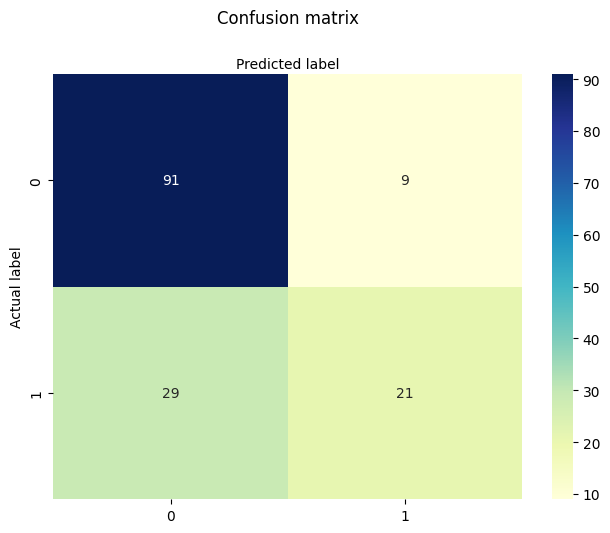

In [168]:
LR_model(X_train,Y_train,X_test,Y_test)

Accuracy: 0.7
Precision: 0.693069306930693
Recall: 0.6862745098039216
NMI:  0.11836984273216311
F-score:  0.6896551724137931


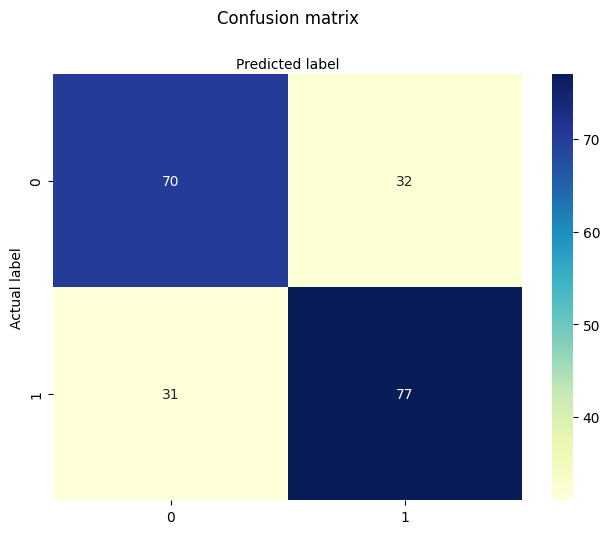

In [99]:
LR_model(X_smote_train,Y_smote_train,X_smote_test,Y_smote_test)

Accuracy: 0.8493150684931506
Precision: 0.782608695652174
Recall: 0.75
NMI:  0.3454605896569629
F-score:  0.7659574468085107


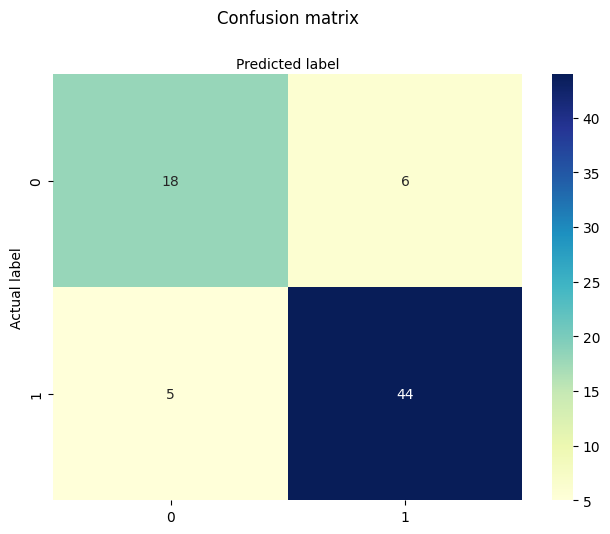

In [100]:
LR_model(X_smoteenn_train,Y_smoteenn_train,X_smoteenn_test,Y_smoteenn_test)

Accuracy: 0.6777777777777778
Precision: 0.6538461538461539
Recall: 0.7555555555555555
NMI:  0.09666917598859007
F-score:  0.7010309278350516


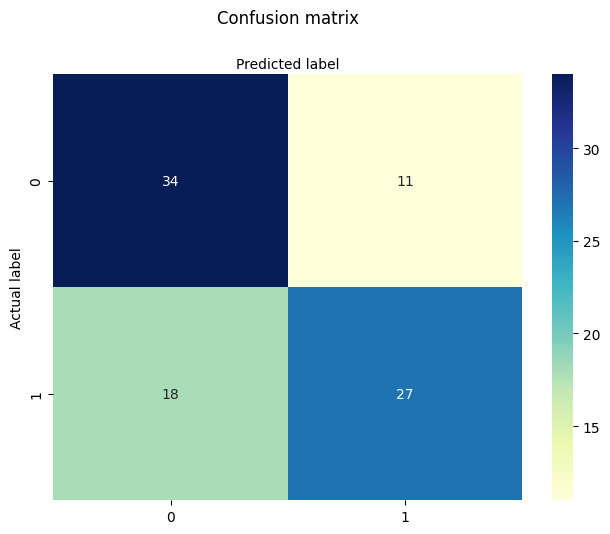

In [101]:
LR_model(X_cc_train,Y_cc_train,X_cc_test,Y_cc_test)

#Decision tree

In [130]:
def DT_model(X_train,Y_train,X_test,Y_test):
      # Create Decision Tree classifer object
      clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

      # Train Decision Tree Classifer
      clf = clf.fit(X_train,Y_train)

      #Predict the response for test dataset
      y_pred_D = clf.predict(X_test)
      print("Accuracy:",accuracy_score(Y_test, y_pred_D))
      print("Precision:",precision_score(Y_test, y_pred_D))
      print("Recall:",recall_score(Y_test, y_pred_D))
      print('NMI: ',nmi(Y_test,y_pred_D))
      print("F-score: ", f1(Y_test,y_pred_D))
      return clf

In [133]:
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
def print_tree(clf):
        feature_cols = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
        dot_data = StringIO()
        export_graphviz(clf, out_file=dot_data,
                        filled=True, rounded=True,
                        special_characters=True,class_names=['0','1'])
        graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
        #graph.write_png('image.png')
        Image(graph.create_png())

Accuracy: 0.76
Accuracy: 0.76
Precision: 0.7909090909090909
Recall: 0.87
NMI:  0.15182596811532367
F-score:  0.8285714285714286


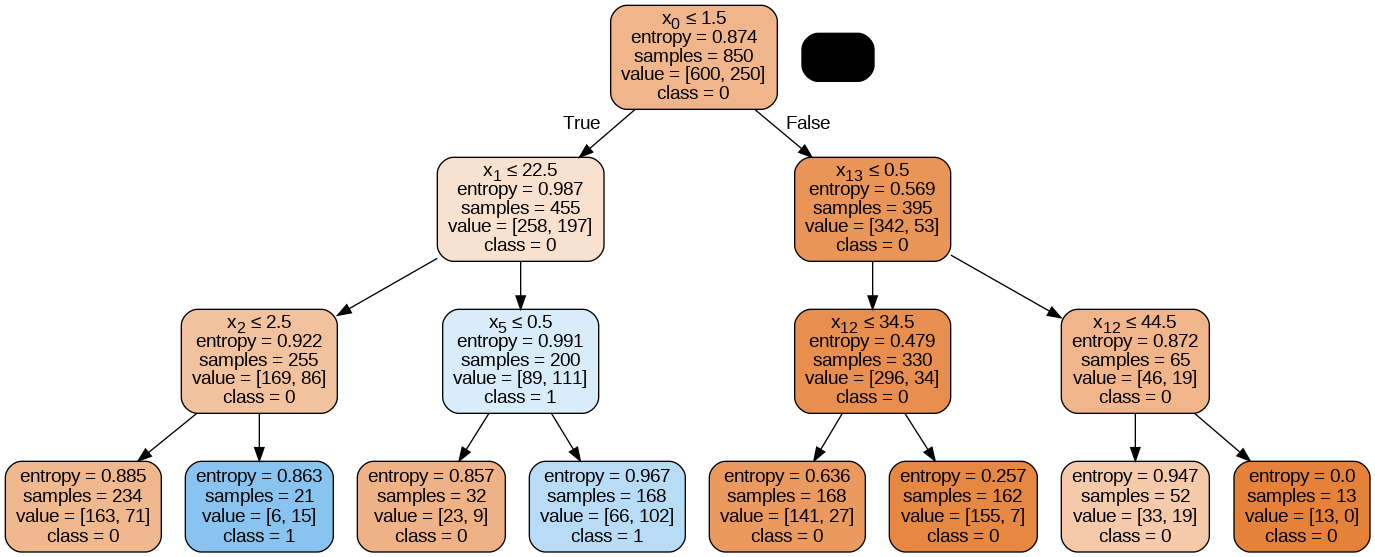

In [173]:
clf=DT_model(X_train,Y_train,X_test,Y_test)
feature_cols = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                        filled=True, rounded=True,
                        special_characters=True,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('image.png')
Image(graph.create_png())

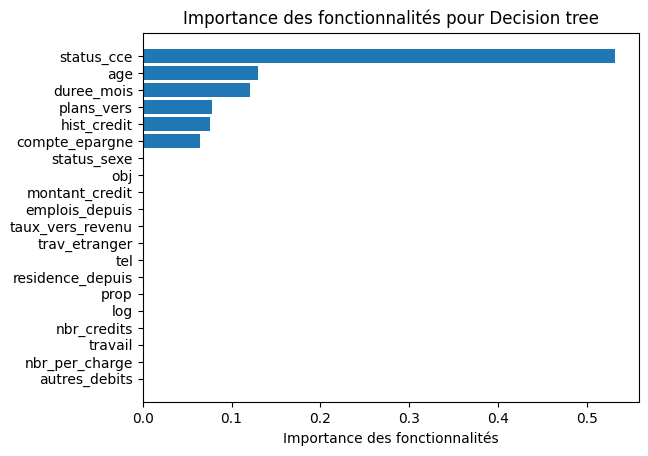

In [175]:
# Obtenir l'importance des fonctionnalités
feature_importances = clf.feature_importances_

# Afficher l'importance des fonctionnalités
feature_names =df.columns
sorted_idx = feature_importances.argsort()

plt.barh(range(X.shape[1]), feature_importances[sorted_idx], align="center")
plt.yticks(range(X.shape[1]), [feature_names[i] for i in sorted_idx])
plt.xlabel("Importance des fonctionnalités")
plt.title("Importance des fonctionnalités pour Decision tree")
plt.show()

Accuracy: 0.7
Accuracy: 0.7
Precision: 0.7468354430379747
Recall: 0.5784313725490197
NMI:  0.12557212302014764
F-score:  0.6519337016574586


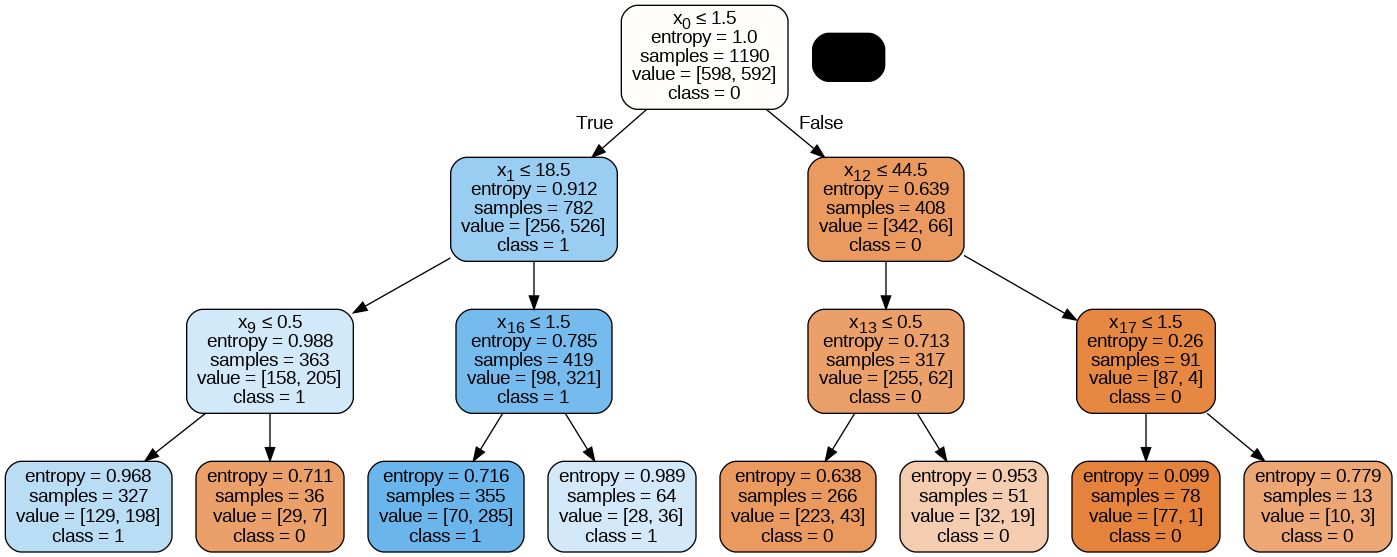

In [176]:
clf=DT_model(X_smote_train,Y_smote_train,X_smote_test,Y_smote_test)
feature_cols = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                        filled=True, rounded=True,
                        special_characters=True,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('image.png')
Image(graph.create_png())

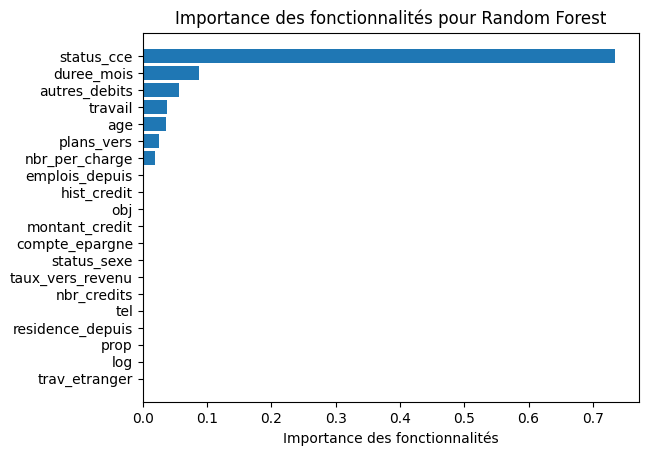

In [177]:
# Obtenir l'importance des fonctionnalités
feature_importances = clf.feature_importances_

# Afficher l'importance des fonctionnalités
feature_names =df.columns
sorted_idx = feature_importances.argsort()

plt.barh(range(X.shape[1]), feature_importances[sorted_idx], align="center")
plt.yticks(range(X.shape[1]), [feature_names[i] for i in sorted_idx])
plt.xlabel("Importance des fonctionnalités")
plt.title("Importance des fonctionnalités pour Random Decision tree")
plt.show()

Accuracy: 0.7222222222222222
Accuracy: 0.7222222222222222
Precision: 0.7777777777777778
Recall: 0.6222222222222222
NMI:  0.157412542372757
F-score:  0.6913580246913581


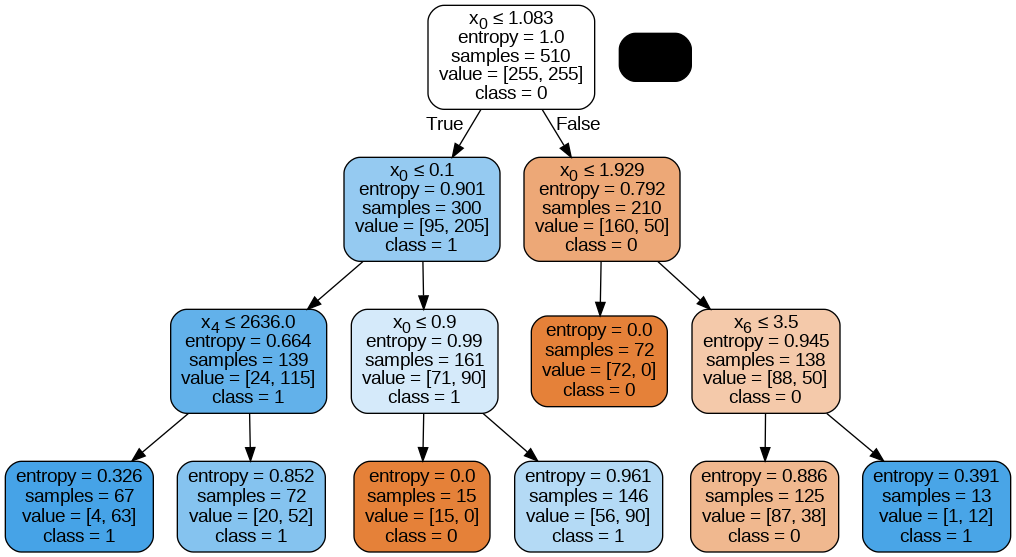

In [178]:
clf=DT_model(X_cc_train,Y_cc_train,X_cc_test,Y_cc_test)
feature_cols = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                        filled=True, rounded=True,
                        special_characters=True,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('image.png')
Image(graph.create_png())

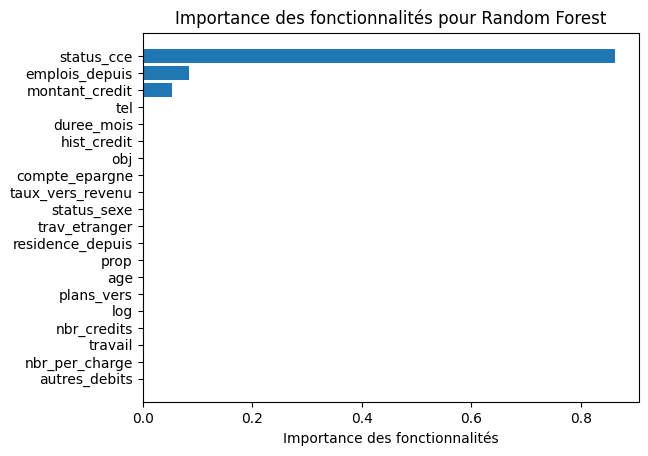

In [179]:
# Obtenir l'importance des fonctionnalités
feature_importances = clf.feature_importances_

# Afficher l'importance des fonctionnalités
feature_names =df.columns
sorted_idx = feature_importances.argsort()

plt.barh(range(X.shape[1]), feature_importances[sorted_idx], align="center")
plt.yticks(range(X.shape[1]), [feature_names[i] for i in sorted_idx])
plt.xlabel("Importance des fonctionnalités")
plt.title("Importance des fonctionnalités pour Decision tree")
plt.show()

Accuracy: 0.7397260273972602
Accuracy: 0.7397260273972602
Precision: 0.5757575757575758
Recall: 0.7916666666666666
NMI:  0.17962941229815865
F-score:  0.6666666666666667


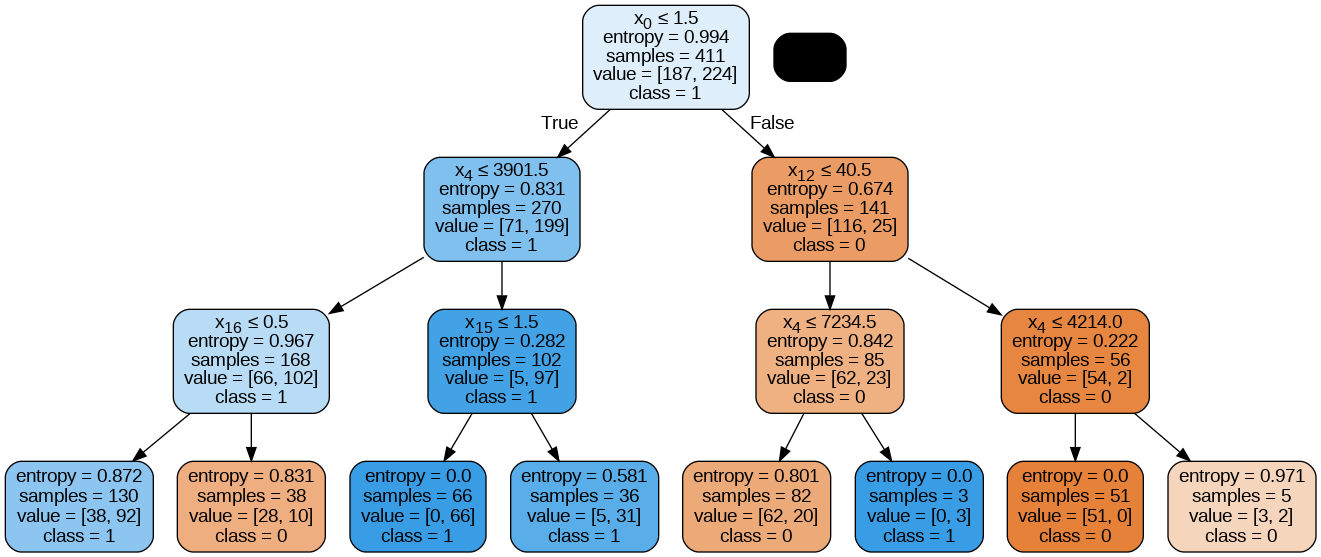

In [180]:
clf=DT_model(X_smoteenn_train,Y_smoteenn_train,X_smoteenn_test,Y_smoteenn_test)
feature_cols = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                        filled=True, rounded=True,
                        special_characters=True,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('image.png')
Image(graph.create_png())

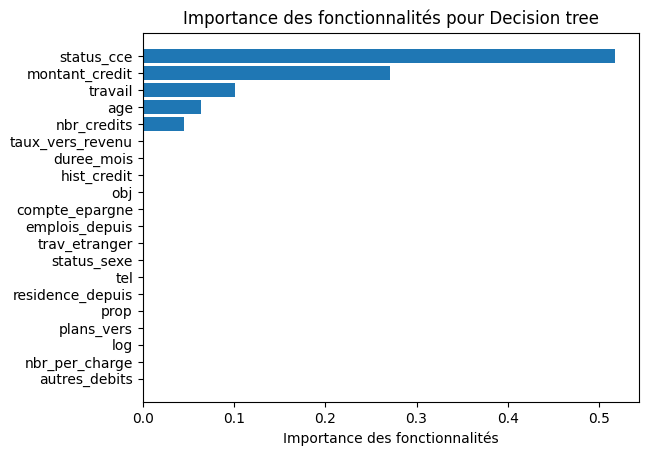

In [182]:
# Obtenir l'importance des fonctionnalités
feature_importances = clf.feature_importances_

# Afficher l'importance des fonctionnalités
feature_names =df.columns
sorted_idx = feature_importances.argsort()

plt.barh(range(X.shape[1]), feature_importances[sorted_idx], align="center")
plt.yticks(range(X.shape[1]), [feature_names[i] for i in sorted_idx])
plt.xlabel("Importance des fonctionnalités")
plt.title("Importance des fonctionnalités pour Decision tree")
plt.show()

#SVM

In [154]:
#Import svm model
from sklearn import svm
def SMV_model(X_train,Y_train,X_test,Y_test):
      #Create a svm Classifier
      clf = svm.SVC(kernel='linear')

      #Train the model using the training sets
      clf.fit(X_train, Y_train)

      #Predict the response for test dataset
      y_pred_svm = clf.predict(X_test)
      print("Accuracy:",accuracy_score(Y_test, y_pred_svm))
      print("Precision:",precision_score(Y_test, y_pred_svm))
      print("Recall:",recall_score(Y_test, y_pred_svm))
      print('NMI: ',nmi(Y_test,y_pred_svm))
      print("F-score: ", f1(Y_test,y_pred_svm))

In [84]:
SMV_model(X_train,Y_train,X_test,Y_test)

KeyboardInterrupt: ignored

#LDA

In [149]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def LDA_model(X_train,Y_train,X_test,Y_test) :
      # define model
      model = LinearDiscriminantAnalysis()
      # define model evaluation method
      cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
      # define grid
      grid = dict()
      grid['solver'] = ['svd', 'lsqr', 'eigen']
      # define search
      search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
      # perform the search
      results = search.fit(X_train,Y_train)
      # summarize
      print('Mean Accuracy: %.3f' % results.best_score_)
      print('Config: %s' % results.best_params_)
      y_pred_lda = search.predict(X_test)
      print("Accuracy:",accuracy_score(Y_test, y_pred_lda))
      print("Precision:",precision_score(Y_test, y_pred_lda))
      print("Recall:",recall_score(Y_test, y_pred_lda))
      print('NMI: ',nmi(Y_test,y_pred_lda))
      print("F-score: ", f1(Y_test,y_pred_lda))
      c=confusion_matrix(Y_test,y_pred_lda)
      class_names=[0,1] # name  of classes
      fig, ax = plt.subplots()
      tick_marks = np.arange(len(class_names))
      plt.xticks(tick_marks, class_names)
      plt.yticks(tick_marks, class_names)
      # create heatmap
      sns.heatmap(pd.DataFrame(c), annot=True, cmap="YlGnBu" ,fmt='g')
      ax.xaxis.set_label_position("top")
      plt.tight_layout()
      plt.title('Confusion matrix', y=1.1)
      plt.ylabel('Actual label')
      plt.xlabel('Predicted label')

Mean Accuracy: 0.742
Config: {'solver': 'lsqr'}
Accuracy: 0.7533333333333333
Precision: 0.7603305785123967
Recall: 0.92
NMI:  0.139082469421944
F-score:  0.832579185520362


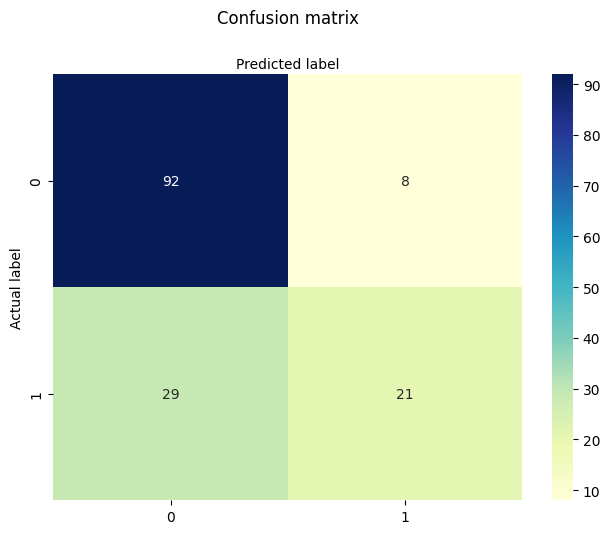

In [150]:
LDA_model(X_train,Y_train,X_test,Y_test)

Mean Accuracy: 0.750
Config: {'solver': 'svd'}
Accuracy: 0.7333333333333333
Precision: 0.7446808510638298
Recall: 0.6862745098039216
NMI:  0.16385399975384535
F-score:  0.7142857142857144


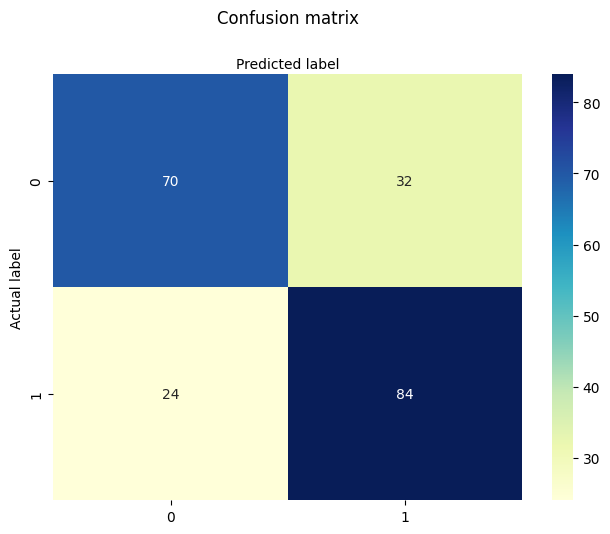

In [151]:
LDA_model(X_smote_train,Y_smote_train,X_smote_test,Y_smote_test)

Mean Accuracy: 0.795
Config: {'solver': 'svd'}
Accuracy: 0.8493150684931506
Precision: 0.782608695652174
Recall: 0.75
NMI:  0.3454605896569629
F-score:  0.7659574468085107


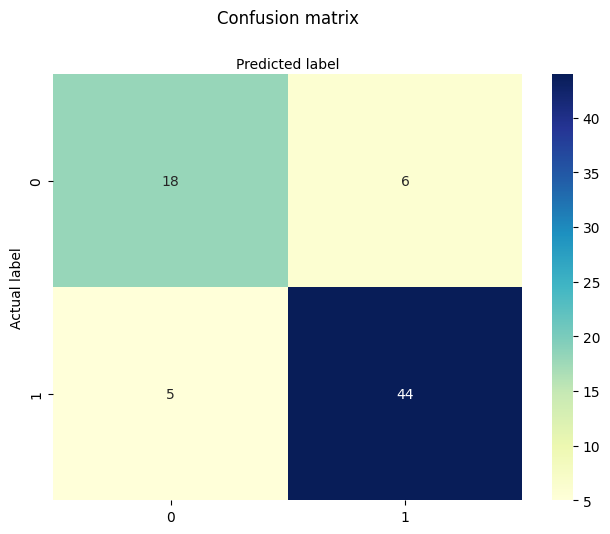

In [152]:
LDA_model(X_smoteenn_train,Y_smoteenn_train,X_smoteenn_test,Y_smoteenn_test)

Mean Accuracy: 0.690
Config: {'solver': 'svd'}
Accuracy: 0.6666666666666666
Precision: 0.6470588235294118
Recall: 0.7333333333333333
NMI:  0.08388155793636316
F-score:  0.6875


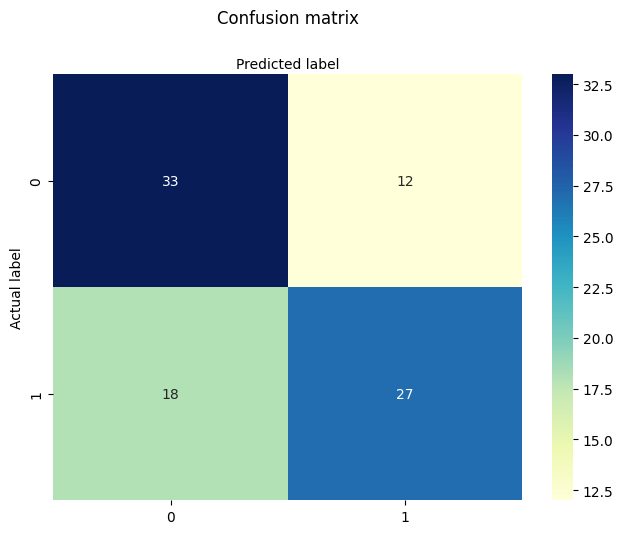

In [153]:
LDA_model(X_cc_train,Y_cc_train,X_cc_test,Y_cc_test)

#QDA

In [144]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
def QDA_model(X_train,Y_train,X_test,Y_test):
      clf = QDA()
      clf.fit(X_train, Y_train)
      y_pred_qda = clf.predict(X_test)
      print("Accuracy:",accuracy_score(Y_test, y_pred_qda))
      print("Precision:",precision_score(Y_test, y_pred_qda))
      print("Recall:",recall_score(Y_test, y_pred_qda))
      print('NMI: ',nmi(Y_test,y_pred_qda))
      print("F-score: ", f1(Y_test,y_pred_qda))
      c=confusion_matrix(Y_test,y_pred_qda)
      class_names=[0,1] # name  of classes
      fig, ax = plt.subplots()
      tick_marks = np.arange(len(class_names))
      plt.xticks(tick_marks, class_names)
      plt.yticks(tick_marks, class_names)
      # create heatmap
      sns.heatmap(pd.DataFrame(c), annot=True, cmap="YlGnBu" ,fmt='g')
      ax.xaxis.set_label_position("top")
      plt.tight_layout()
      plt.title('Confusion matrix', y=1.1)
      plt.ylabel('Actual label')
      plt.xlabel('Predicted label')

Accuracy: 0.76
Precision: 0.8018867924528302
Recall: 0.85
NMI:  0.1555049707237453
F-score:  0.8252427184466019


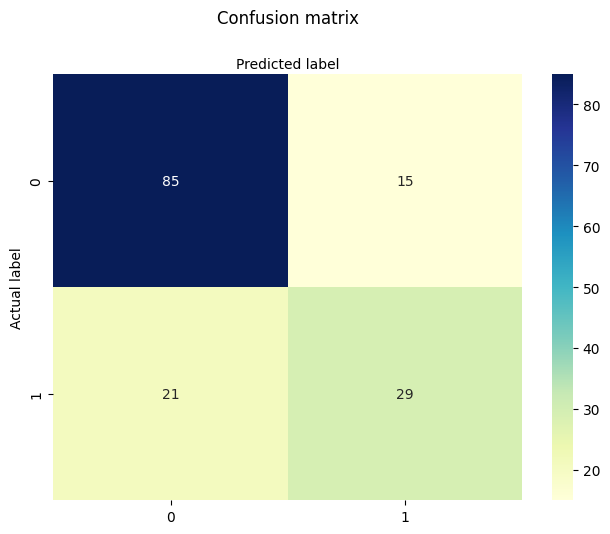

In [145]:
QDA_model(X_train,Y_train,X_test,Y_test)

Accuracy: 0.719047619047619
Precision: 0.7721518987341772
Recall: 0.5980392156862745
NMI:  0.15230192991288316
F-score:  0.6740331491712707


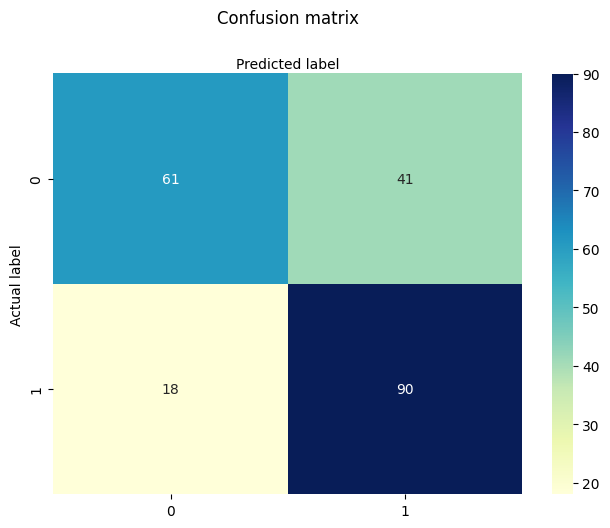

In [146]:
QDA_model(X_smote_train,Y_smote_train,X_smote_test,Y_smote_test)

Accuracy: 0.7671232876712328
Precision: 0.6521739130434783
Recall: 0.625
NMI:  0.17011656209662848
F-score:  0.6382978723404256


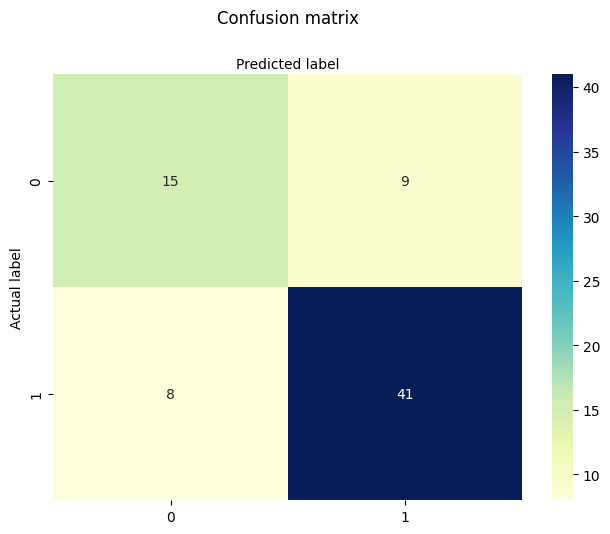

In [147]:
QDA_model(X_smoteenn_train,Y_smoteenn_train,X_smoteenn_test,Y_smoteenn_test)

Accuracy: 0.7333333333333333
Precision: 0.7837837837837838
Recall: 0.6444444444444445
NMI:  0.17198947766621223
F-score:  0.7073170731707318


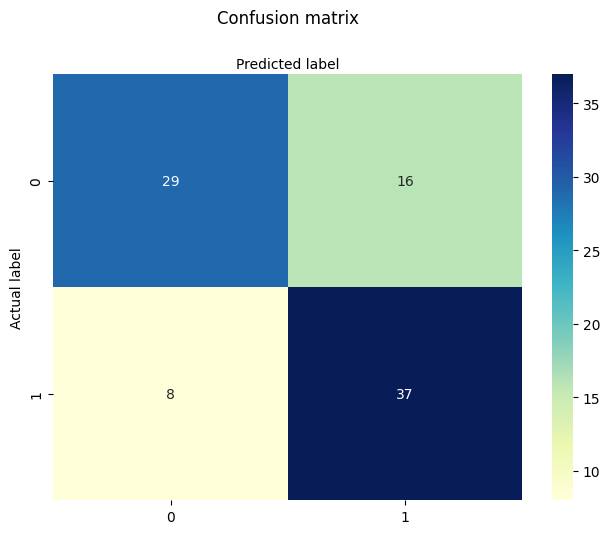

In [148]:
QDA_model(X_cc_train,Y_cc_train,X_cc_test,Y_cc_test)